# COMS4060A - Introduction of Data Visualisation & Exploration: Assignment 1 

## Group Members
* Lisa Godiwn - 2437980
* Nihal Ranchod - 2427378
* Zach Schwark - 2434346

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Question 1: Data Cleaning

In [2]:
df = pd.read_csv('logbook_assignment1.csv')

# View initial first few rows
df.head()

C:\Users\zachs\AppData\Local\Temp\ipykernel_27424\2876097302.py:1: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('logbook_assignment1.csv')


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
0,"Cooling System, Heating System, Lights, Spark ...",Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...


[1.1] Date Fields: 1. Identify what percentage of date_fueled entries that are not proper dates.
* Checking valid date for any order of 'mmm dd yyyy'

In [3]:
from dateutil.parser import parse

# Function to check if a string is a valid date
def is_valid_date(date_str):
    if isinstance(date_str, str) and date_str.strip():
        try:
            parse(date_str, fuzzy=False) # fuzzy paramter ensures that the parsing is strict and does not allow partial matches.
            return True
        except ValueError:
            return False
    return False

# Apply the function to the date_fueled column
df['is_valid_date'] = df['date_fueled'].apply(is_valid_date)

# Calculate the percentage of improper dates
total_entries = len(df)
improper_dates_count = df['is_valid_date'].value_counts().get(False, 0)
percentage_improper_dates = (improper_dates_count / total_entries) * 100

print(f"Total entries: {total_entries}")
print(f"Improper date entries: {improper_dates_count}")
print(f"Percentage of improper dates: {percentage_improper_dates:.2f}%")

Total entries: 1174870
Improper date entries: 135141
Percentage of improper dates: 11.50%


[1.1] Date Fields: 2. If date fueled is not entered correctly (or is not a date), and the date
captured is a valid date, then fill in this value as a proxy.

In [4]:
# Function to fill in date_fueled with date_captured if date_fueled is invalid
def fill_invalid_date(row):
    if not is_valid_date(row['date_fueled']):
        if is_valid_date(row['date_captured']):
            return row['date_captured']
    return row['date_fueled']

# Apply the function to the DataFrame
df['date_fueled'] = df.apply(fill_invalid_date, axis=1)

# Apply the function to check if the date_fueled is valid
df['is_valid_date'] = df['date_fueled'].apply(is_valid_date)

# Calculate the percentage of improper dates
total_entries = len(df)
improper_dates_count = df['is_valid_date'].value_counts().get(False, 0)
percentage_improper_dates = (improper_dates_count / total_entries) * 100

# Output the results
print(f"Total entries: {total_entries}")
print(f"Improper date entries: {improper_dates_count}")
print(f"Percentage of improper dates: {percentage_improper_dates:.2f}%")

Total entries: 1174870
Improper date entries: 0
Percentage of improper dates: 0.00%


[1.1] Date Fields: 3. Convert the column to a date format, setting any invalid date fueled entries
to NaT.

In [5]:
# Convert the date_fueled and date_captured column to datetime, setting invalid entries to NaT
df['date_fueled'] = pd.to_datetime(df['date_fueled'], errors='coerce')
df['date_captured'] = pd.to_datetime(df['date_captured'], errors='coerce')

df.head()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,is_valid_date
0,2022-04-07,2022-04-07,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,True
1,2012-11-07,2016-08-30,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150,True
2,2012-09-22,2012-09-28,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...,True
3,2019-05-04,2019-05-04,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233,True
4,2022-02-15,2022-02-15,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...,True


[1.1] Date Fields: 4. Remove dates that are in the future, or dates that are earlier than 2005.
- Removing dates for both 'date_fueled' and 'date_captured' in this range:

    * Consistency Across Columns: If one column (date_fueled or date_captured) has a valid date while the other column has an invalid date (in the future or before 2005), it could lead to inconsistencies. For example, analyzing time differences between fueling and capturing, such inconsistencies could distort the results.

    * Simplification: By removing invalid dates from both columns, it simplifies the data cleaning process, ensuring that all remaining records are within the valid date range.

In [6]:
from datetime import datetime

# Define the date range
start_date = datetime(2005, 1, 1)
end_date = datetime.now()

# Filter out dates that are in the future or earlier than 2005
df = df[(df['date_fueled'] >= start_date) & (df['date_fueled'] <= end_date)]
df = df[(df['date_captured'] >= start_date) & (df['date_captured'] <= end_date)]

[1.1] Date Fields: 5. Plot the distribution of fueling dates and comment on the results.

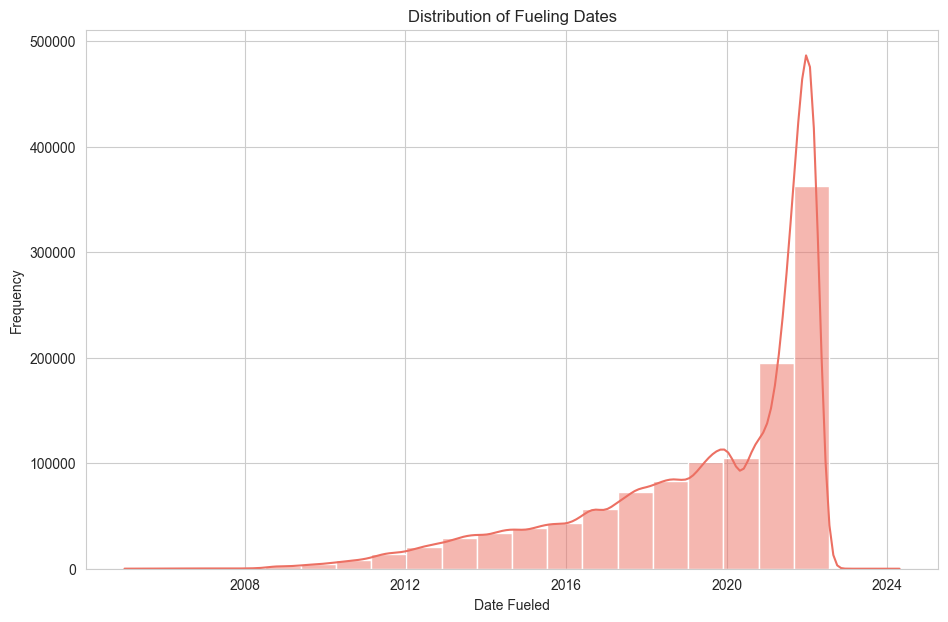

In [7]:
plt.figure(figsize=(11, 7))
sns.set_style('whitegrid')
sns.histplot(df['date_fueled'].dropna(),
                bins='sturges',
                stat='count',
                kde=True,
                color='#ec7063')
plt.title('Distribution of Fueling Dates')
plt.xlabel('Date Fueled')
plt.ylabel('Frequency')
plt.show()


The histogram shows the distribution of valid fueling dates within the specificed range (from 2005 to the current date). 
1. Distribution of Fueling Dates:
    * The data seems to be heavily skewed towards the more recent dates.
    * The KDE line peaks significantly towards the right-hand side of the plot, suggesting that most of the refueling entries occurred within a more condensed recent time period.

2. Historical Refueling Activity:
    * There is a gradual increase in the number of entries over time, with a sharp rise as you approach the more recent dates.
    * This could indicate that the dataset either has more recent entries or that vehicle refueling was recorded more frequently as time progressed.

3. Binning:
    * The histogram bins are wide enough to capture general trends, but there might be clustering towards specific time periods, which the KDE line emphasizes.

[1.2] Numeric Fields: 1. Identify what percentage of gallons, miles, and odometer entries are missing.

In [8]:
# Calculate the percentage of missing values in each of the specified columns
columns = ['gallons', 'miles', 'odometer']
percent_missing = df[columns].isnull().mean() * 100

# Print the results
for column, percentage in percent_missing.items():
    print(f"Percentage of missing entries in '{column}': {percentage:.2f}%")

Percentage of missing entries in 'gallons': 6.32%
Percentage of missing entries in 'miles': 87.60%
Percentage of missing entries in 'odometer': 12.65%


[1.2] Numeric Fields: 2. The miles, gallons and mpg columns are interdependent. If one is missing, the other two can be used to calculate it.

In [9]:
#convert odometer, gallons and miles to floats
df['gallons'] = df['gallons'].astype(str)
df['gallons'] = df['gallons'].str.replace(',', '').str.strip()
df['gallons'] = pd.to_numeric(df['gallons'], errors='coerce')

df['miles'] = df['miles'].astype(str)
df['miles'] = df['miles'].str.replace(',', '').str.strip()
df['miles'] = pd.to_numeric(df['miles'], errors='coerce')

df['mpg'] = df['mpg'].astype(str)
df['mpg'] = df['mpg'].str.replace(',', '').str.strip()
df['mpg'] = pd.to_numeric(df['mpg'], errors="coerce")

#display the first few rows to check the conversion
print(df[['gallons', 'miles', 'mpg']].head())

#function to calculate missing values
def fill_missing_values(row):
    if pd.isnull(row['miles']) and pd.notnull(row['gallons']) and pd.notnull(row['mpg']):
        row['miles'] = row['gallons'] * row['mpg']
    elif pd.isnull(row['gallons']) and pd.notnull(row['miles']) and pd.notnull(row['mpg']):
        row['gallons'] = row['miles'] / row['mpg']
    elif pd.isnull(row['mpg']) and pd.notnull(row['miles']) and pd.notnull(row['gallons']):
        row['mpg'] = row['miles'] / row['gallons']
    return row

# Apply the function to each row in the DataFrame
df = df.apply(fill_missing_values, axis=1)

# Display the updated DataFrame to check the changes
print(df[['miles', 'gallons', 'mpg']])

   gallons  miles   mpg
0      NaN    NaN   NaN
1   12.120    NaN  31.6
2    7.991    NaN  28.5
3   10.575    NaN  46.8
4   11.651  244.4  21.0
            miles  gallons   mpg
0             NaN      NaN   NaN
1        382.9920   12.120  31.6
2        227.7435    7.991  28.5
3        494.9100   10.575  46.8
4        244.4000   11.651  21.0
...           ...      ...   ...
1174865  335.2822   13.046  25.7
1174866  252.7400   12.637  20.0
1174867  285.0570   10.002  28.5
1174868  382.9945   10.493  36.5
1174869    0.0000   17.350   0.0

[1172225 rows x 3 columns]


[1.2] Numeric Fields: 3. The values will be read in as objects (or strings) by Pandas. Convert these values to float (note the point above about commas in the value).

In [10]:
print(df[['odometer', 'cost_per_gallon', 'total_spent']].head())

df['odometer'] = df['odometer'].astype(str)
df['odometer'] = df['odometer'].str.replace(',', '').str.strip()
df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')

# Function to clean and convert to float
def clean_and_convert(value):
    if pd.isna(value):
        return None
    # Remove commas
    value = value.replace(',', '')
    # Remove currency symbols
    value = re.sub(r'[^\d.]', '', value)
    try:
        return float(value)
    except ValueError:
        return None

# Apply the function to create new float columns
df['cost_per_gallon_float'] = df['cost_per_gallon'].apply(clean_and_convert)
df['total_spent_float'] = df['total_spent'].apply(clean_and_convert)

df.head()

   odometer cost_per_gallon total_spent
0   73,370              NaN         NaN
1   11,983           $5.599      $67.86
2   98,233            £5.45      £43.53
3  163,802            £5.11      £54.00
4       NaN          $3.029      $35.29


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,is_valid_date,cost_per_gallon_float,total_spent_float
0,2022-04-07,2022-04-07,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,True,NaN,NaN
1,2012-11-07,2016-08-30,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,True,5.599,67.86
2,2012-09-22,2012-09-28,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,True,5.450,43.53
3,2019-05-04,2019-05-04,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,True,5.110,54.00
4,2022-02-15,2022-02-15,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,True,3.029,35.29


In [11]:
df.dtypes

date_fueled              datetime64[ns]
date_captured            datetime64[ns]
odometer                        float64
gallons                         float64
cost_per_gallon                  object
total_spent                      object
mpg                             float64
miles                           float64
user_url                         object
is_valid_date                      bool
cost_per_gallon_float           float64
total_spent_float               float64
dtype: object

### Question 2: Feature Engineering

[2.1] 1. Create a new column with the currency.

In [12]:
# Define a regular expression pattern to match all characters until the first digit
currency_pattern = r'^([^\d]+)'

# Extract the currency symbols/abbreviations from the cost_per_gallon column
df['currency'] = df['cost_per_gallon'].str.extract(currency_pattern, expand=False).str.strip()

print(df['currency'].value_counts())
df.head()

currency
$      738396
£       86147
€       58441
CA$     46234
R       36034
        ...  
CV$        11
KGS         9
L$          9
IQD         8
YR          4
Name: count, Length: 121, dtype: int64


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,is_valid_date,cost_per_gallon_float,total_spent_float,currency
0,2022-04-07,2022-04-07,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,True,NaN,NaN,NaN
1,2012-11-07,2016-08-30,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,True,5.599,67.86,$
2,2012-09-22,2012-09-28,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,True,5.450,43.53,£
3,2019-05-04,2019-05-04,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,True,5.110,54.00,£
4,2022-02-15,2022-02-15,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,True,3.029,35.29,$


[2.1] 2. Create a new column containing the float value of the total spend and the cost per gallon.

In [13]:
# Define a regular expression pattern to match the numeric part
numeric_pattern = r'(\d+\.\d+|\d+)'

# Extract the numeric part of the cost_per_gallon column and convert it to float
df['cost_per_gallon_float'] = df['cost_per_gallon'].str.extract(numeric_pattern, expand=False).astype(float)

# Calculate the total spend by multiplying the cost per gallon by the number of gallons
df['total_spend'] = df['cost_per_gallon_float'] * df['gallons'].astype(float)

df.head()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,is_valid_date,cost_per_gallon_float,total_spent_float,currency,total_spend
0,2022-04-07,2022-04-07,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,True,NaN,NaN,NaN,NaN
1,2012-11-07,2016-08-30,11983.0,12.120,$5.599,$67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,True,5.599,67.86,$,67.859880
2,2012-09-22,2012-09-28,98233.0,7.991,£5.45,£43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,True,5.450,43.53,£,43.550950
3,2019-05-04,2019-05-04,163802.0,10.575,£5.11,£54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,True,5.110,54.00,£,54.038250
4,2022-02-15,2022-02-15,NaN,11.651,$3.029,$35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,True,3.029,35.29,$,35.290879


### Question 3: Vehicle Exploration

#### [3.1]: number of unique users per country

<Axes: xlabel='count', ylabel='currency'>

C:\Users\zachs\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from current font.
  func(*args, **kwargs)
C:\Users\zachs\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


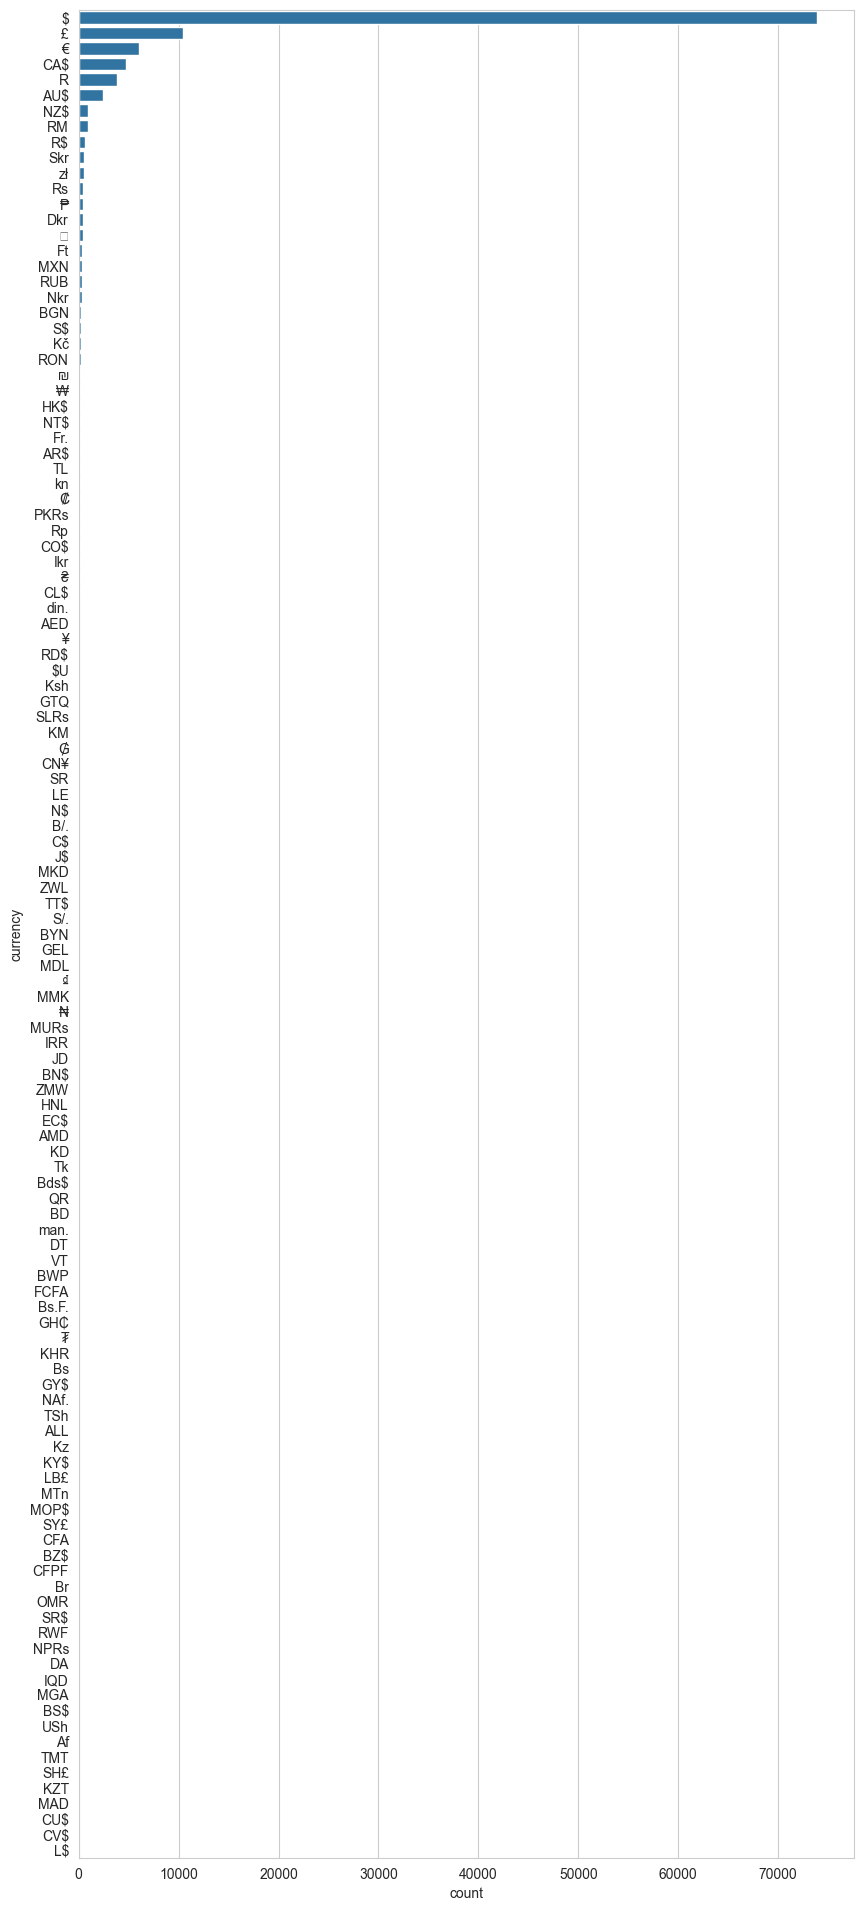

In [14]:
unique_users_df = df.drop_duplicates(subset ='user_url')
#unique_users_df['currency'].value_counts()
plt.figure(figsize=(10, 24))
sns.barplot(unique_users_df['currency'].value_counts(),orient = 'y',log_scale = False)

#### [3.2] number of unique users per day

<Axes: xlabel='caputured_day_of_month', ylabel='count'>

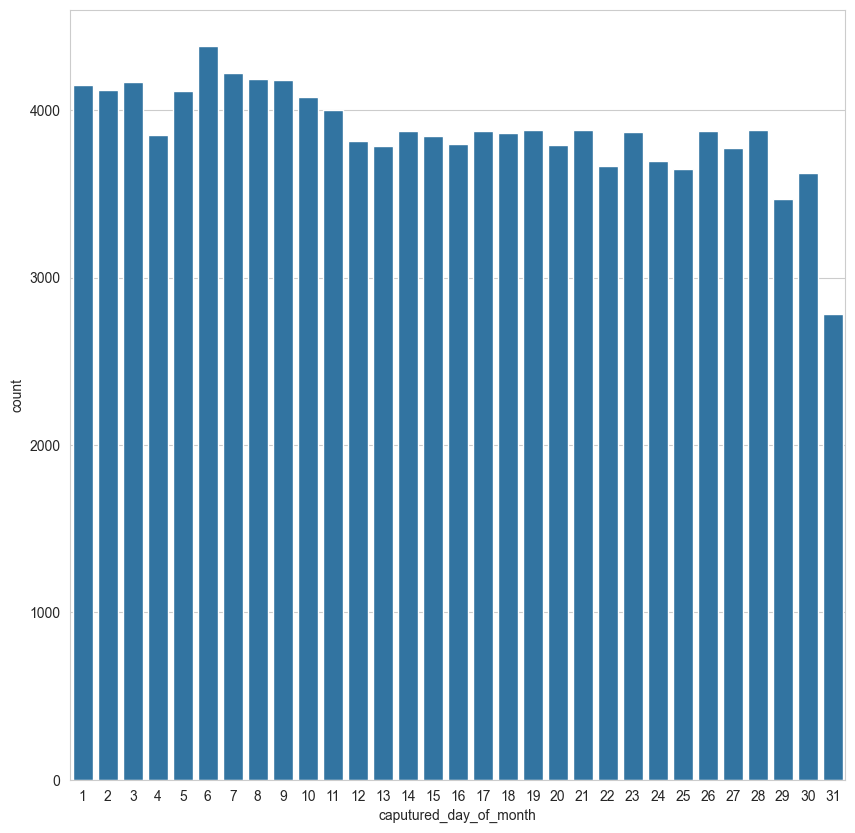

In [15]:

# Extract the day of the month
series_captured_day_of_month = unique_users_df['date_captured'].dt.day
df_captur_day_of_month = unique_users_df.copy()
df_captur_day_of_month['caputured_day_of_month'] = series_captured_day_of_month
#display(df_day_of_month)
plt.figure(figsize=(10, 10))
sns.barplot(df_captur_day_of_month['caputured_day_of_month'].value_counts(),orient = 'x',log_scale = False)

#### [3.3] Look at the distribution of age of the vehicles per country

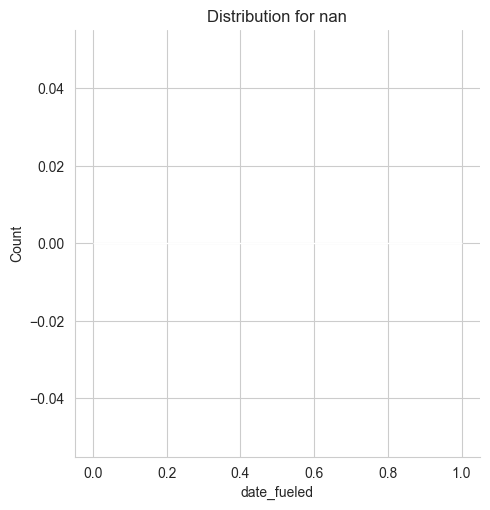

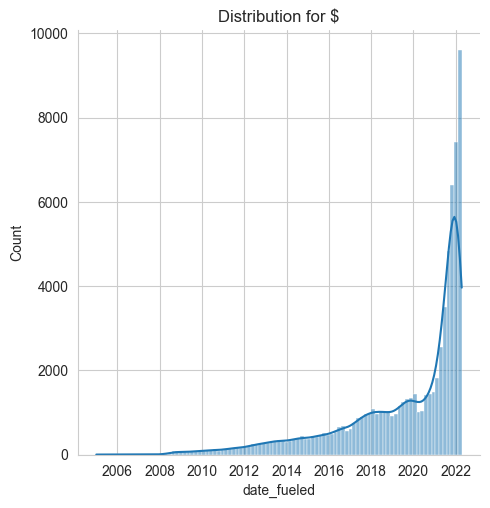

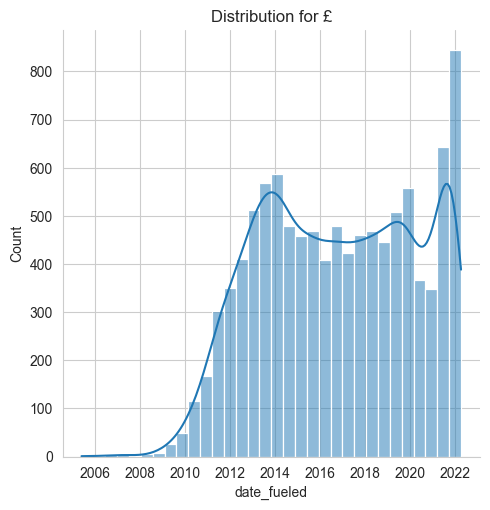

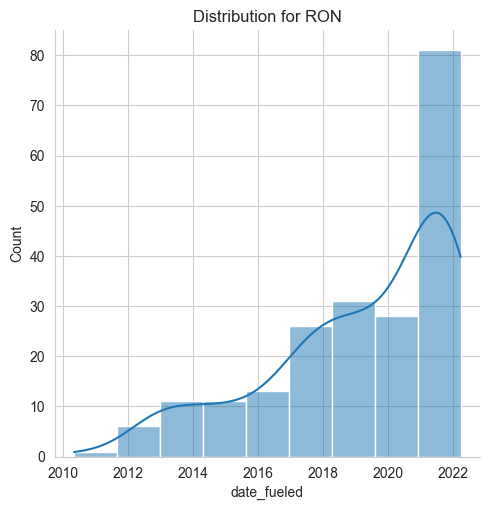

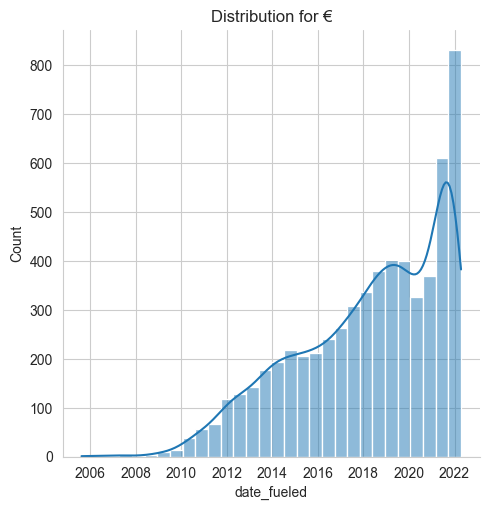

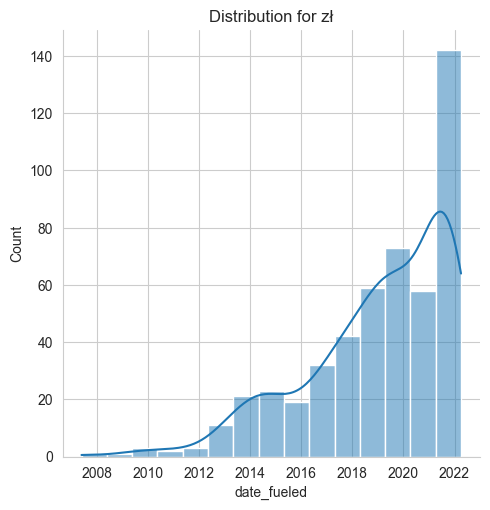

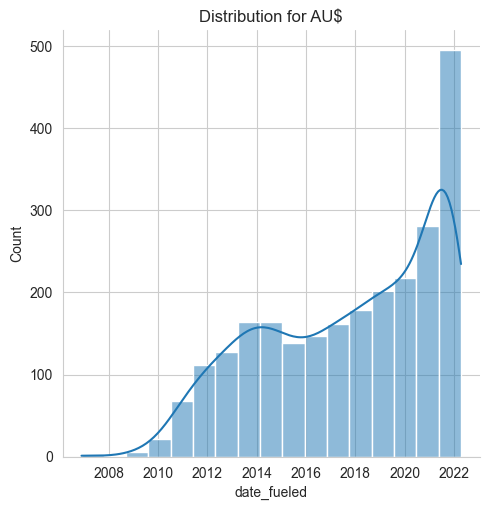

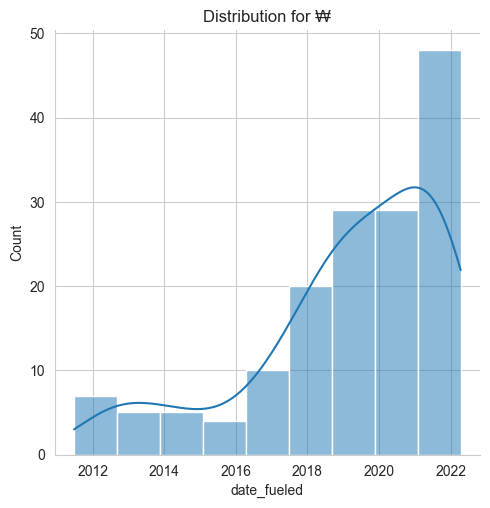

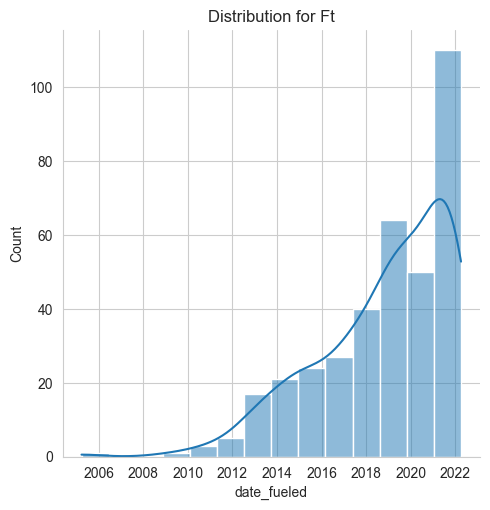

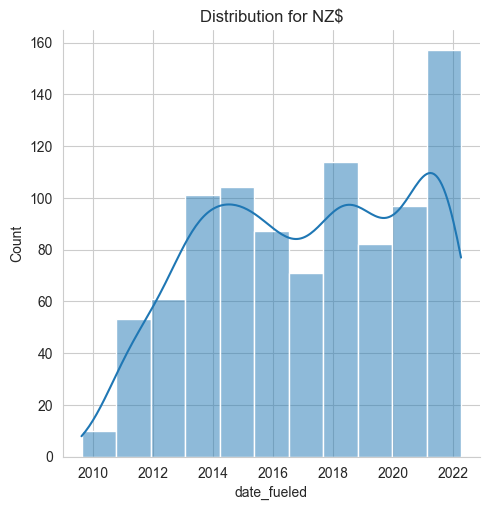

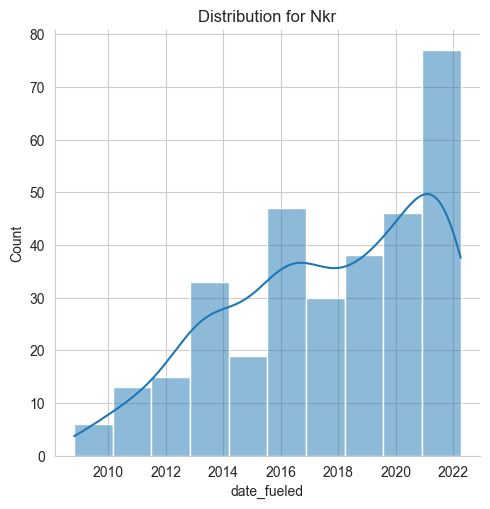

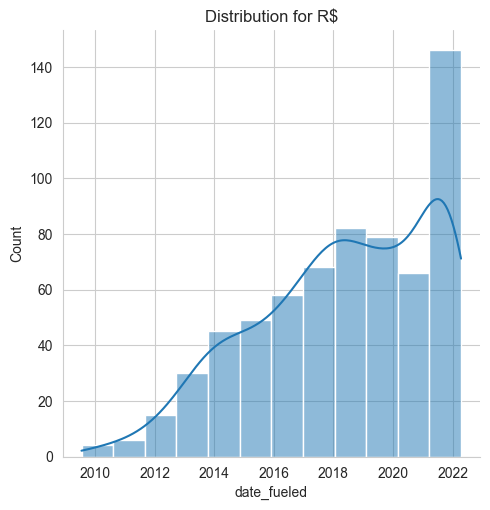

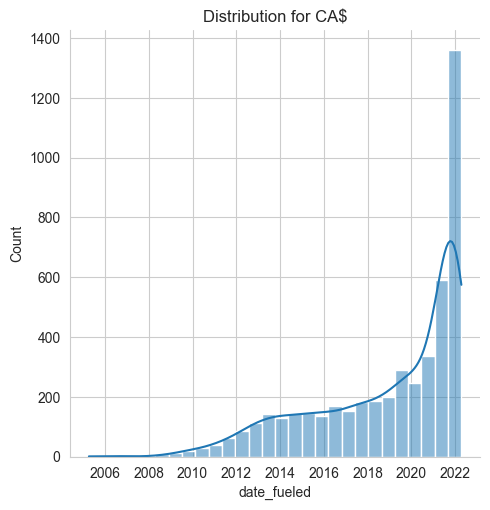

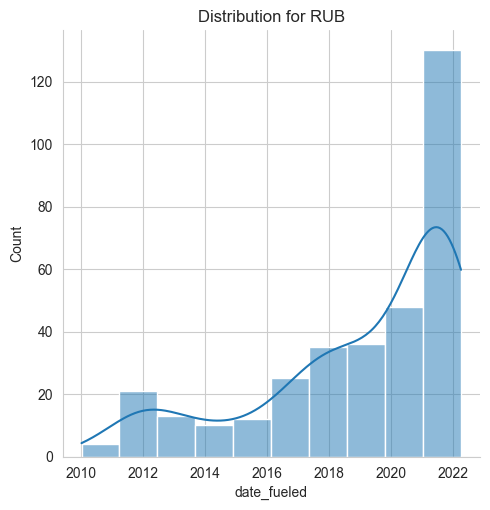

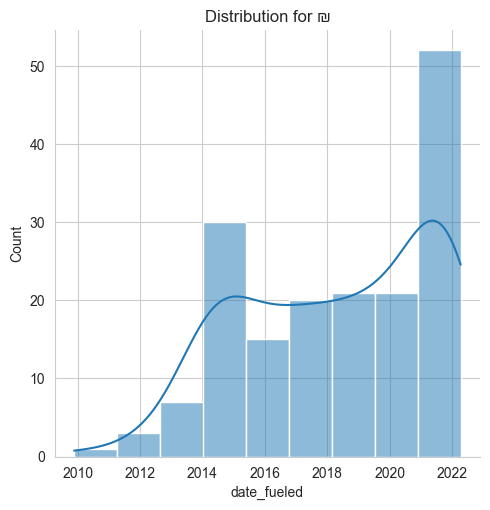

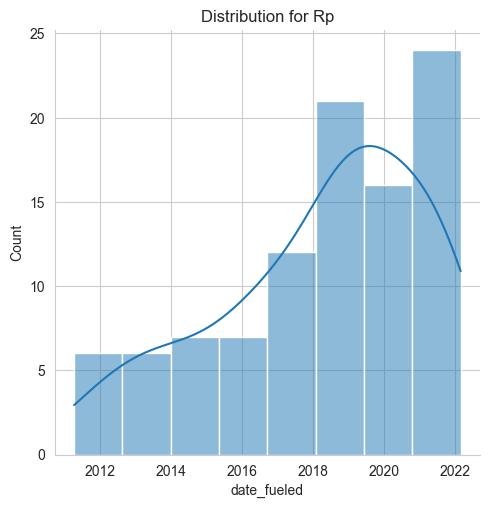

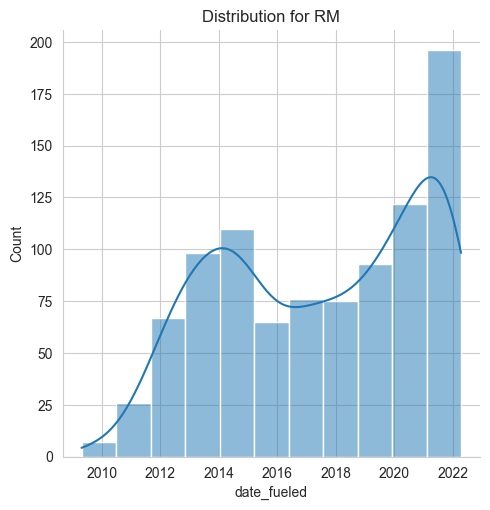

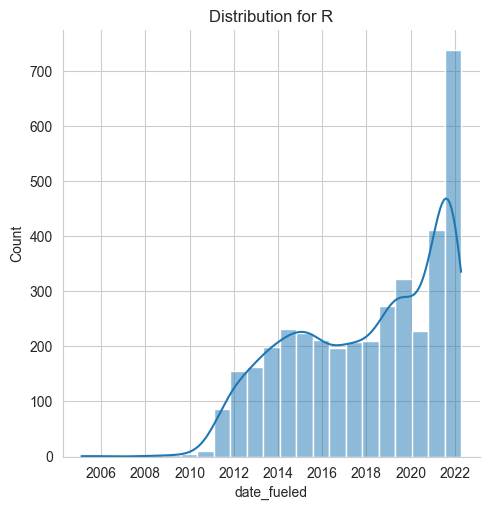

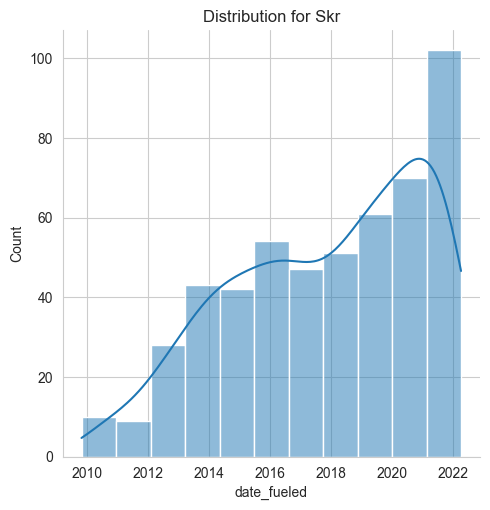

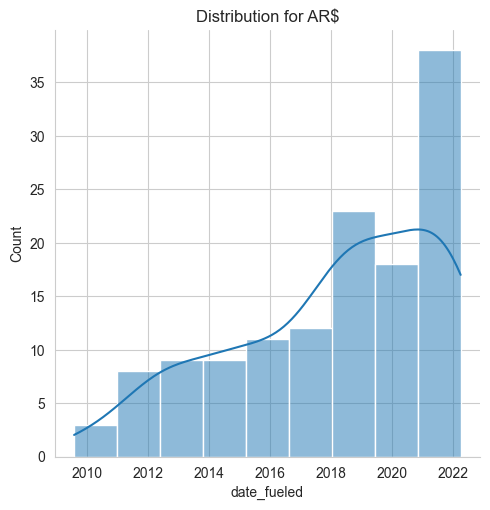

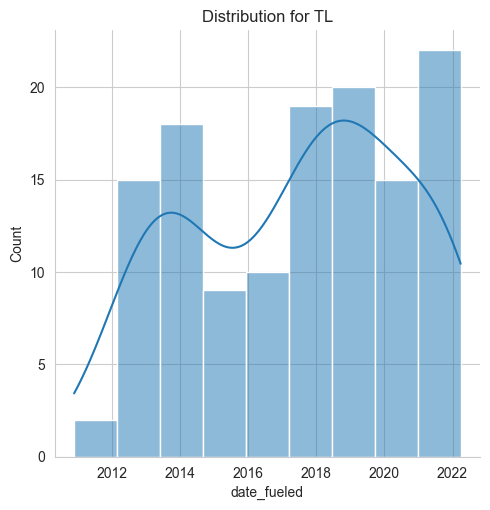

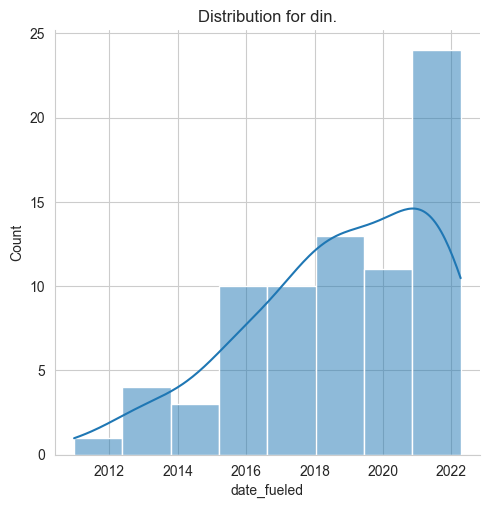

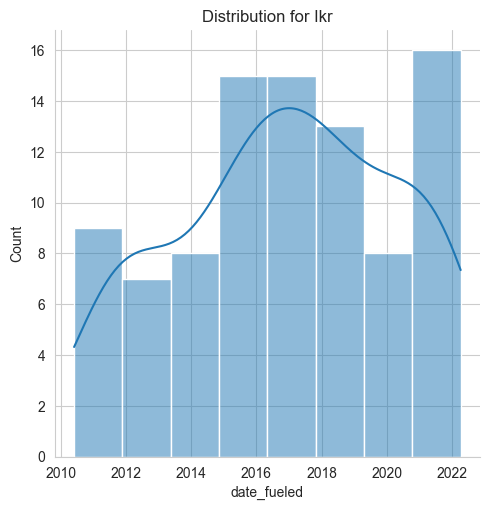

C:\Users\zachs\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


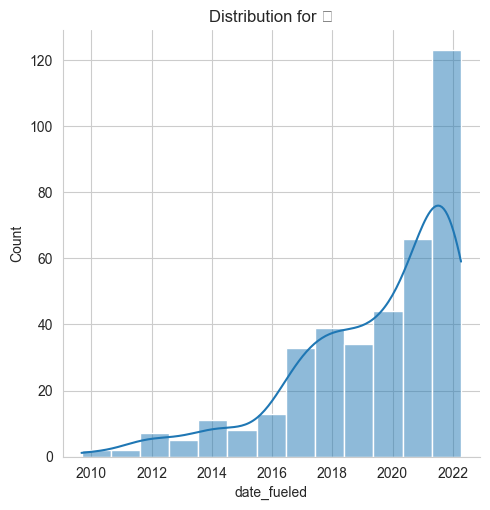

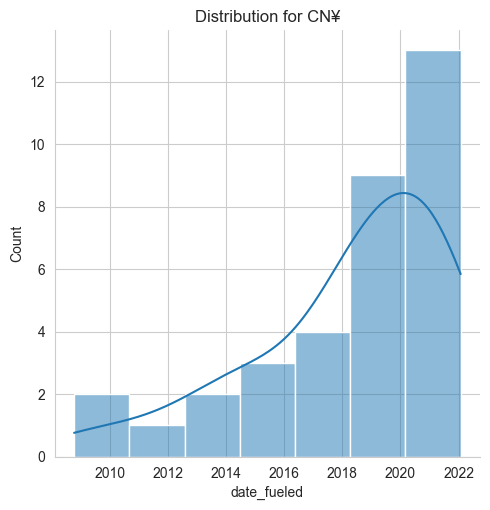

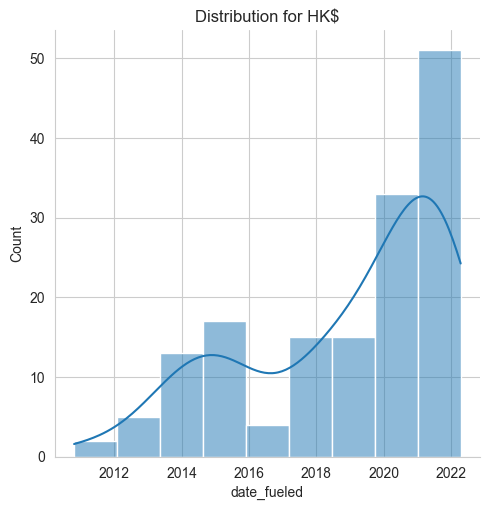

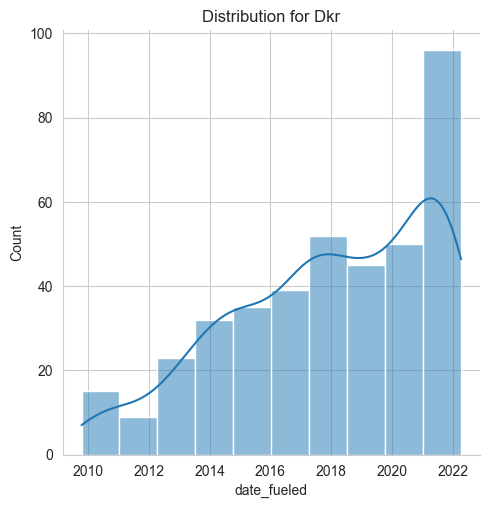

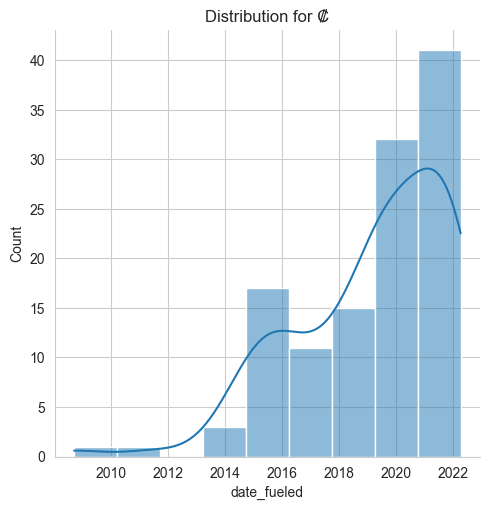

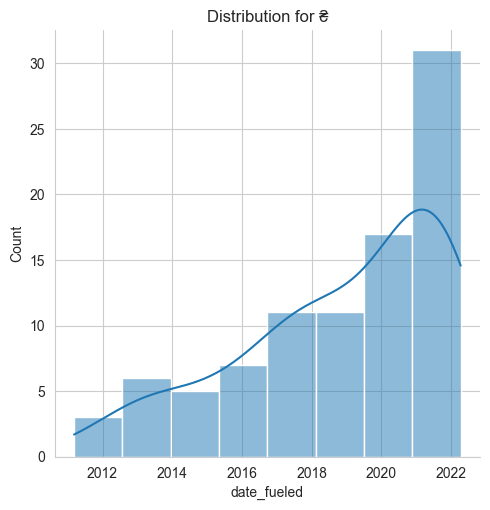

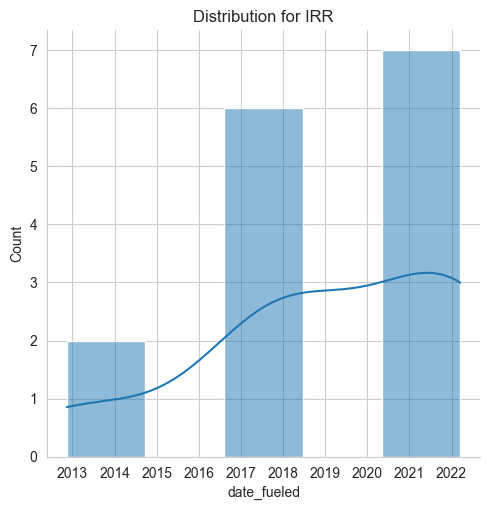

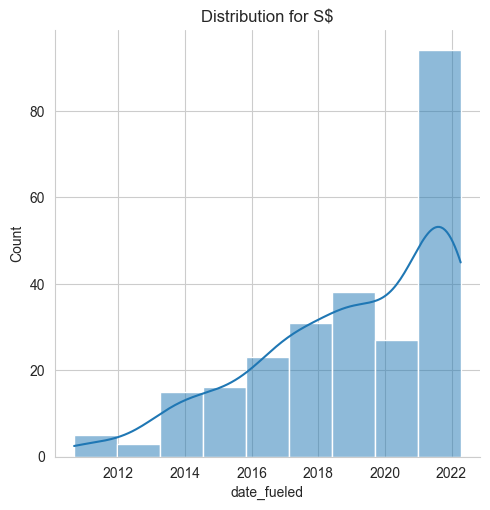

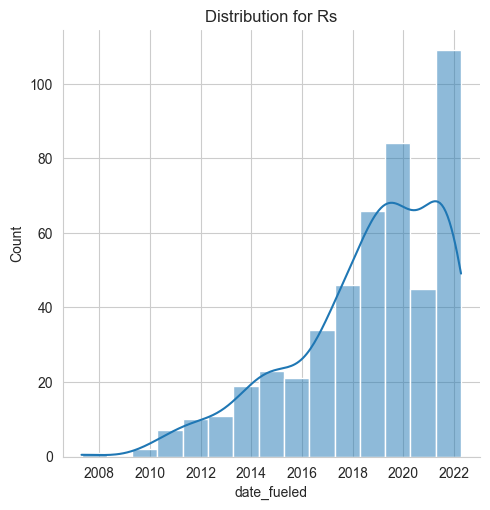

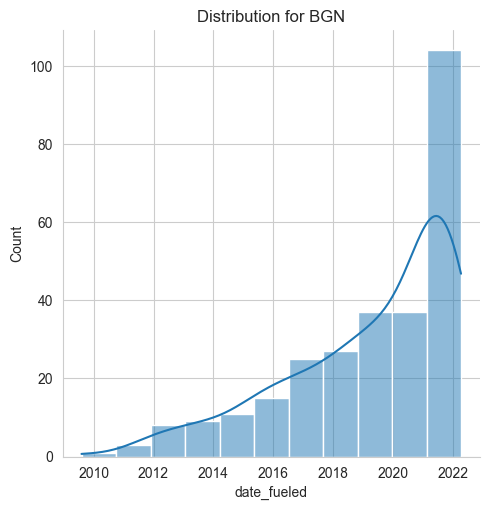

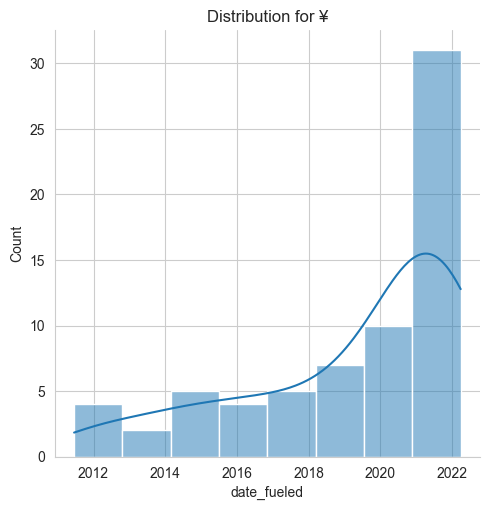

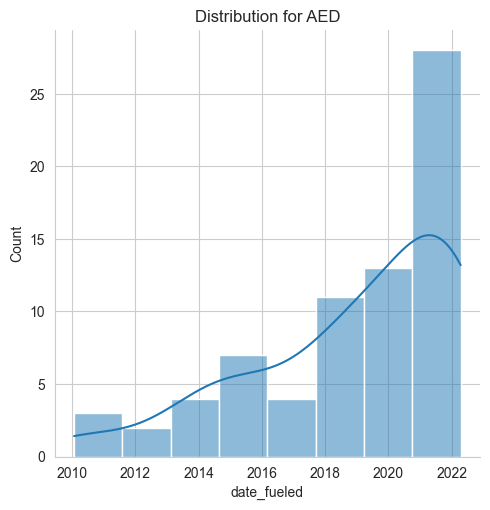

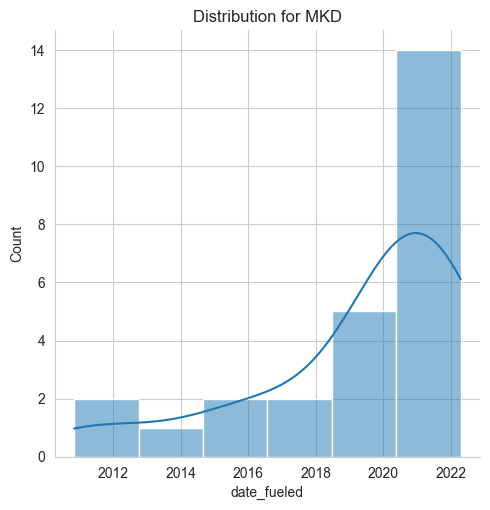

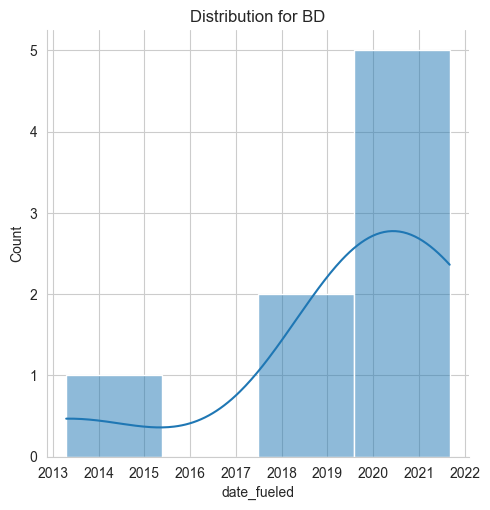

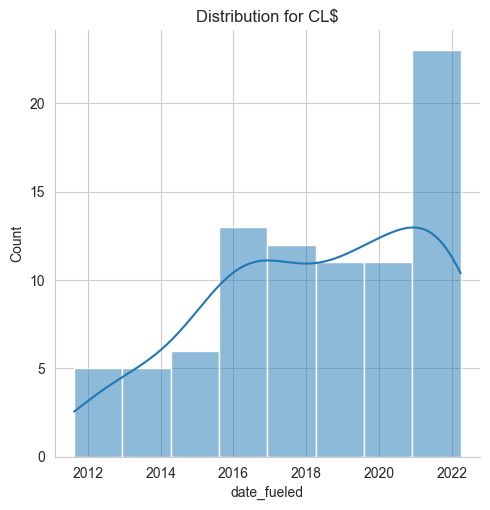

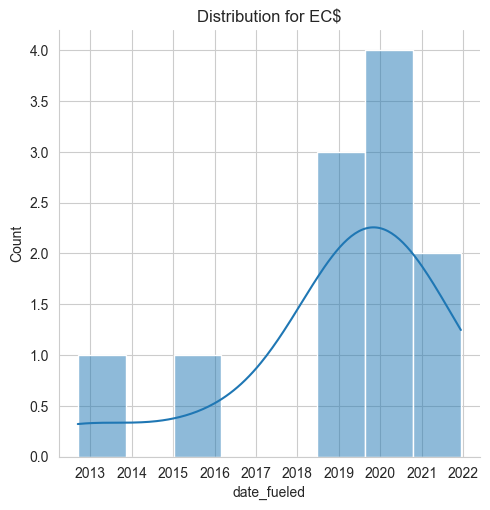

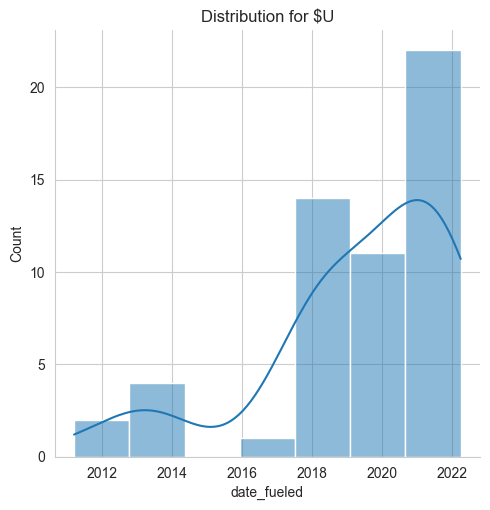

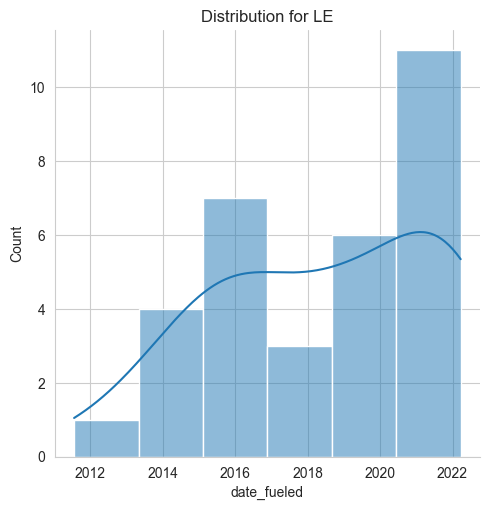

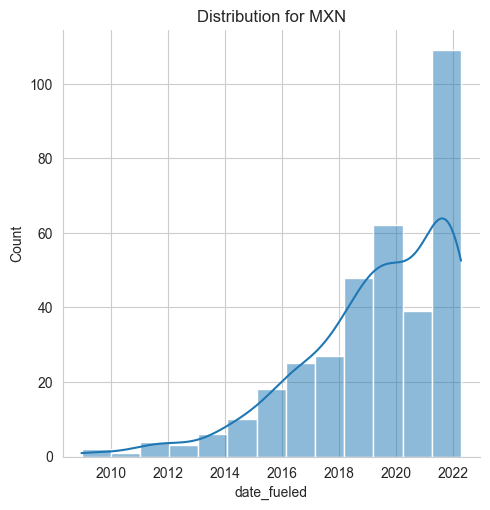

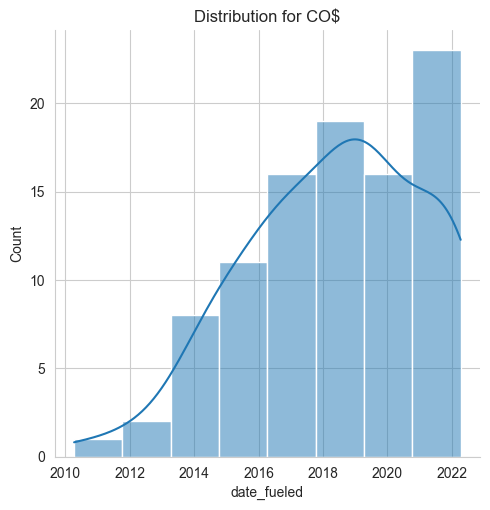

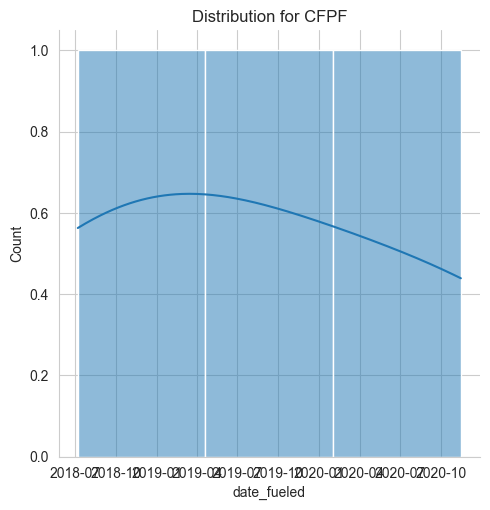

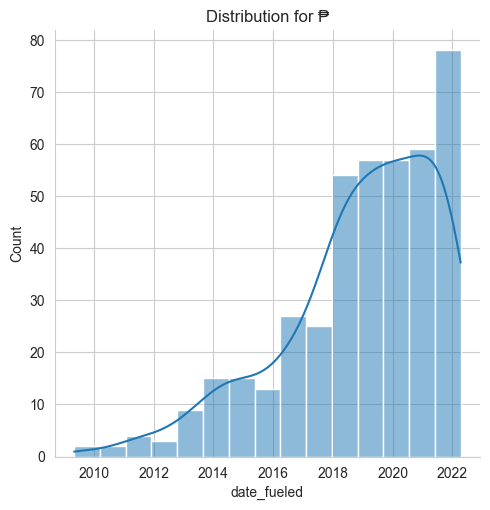

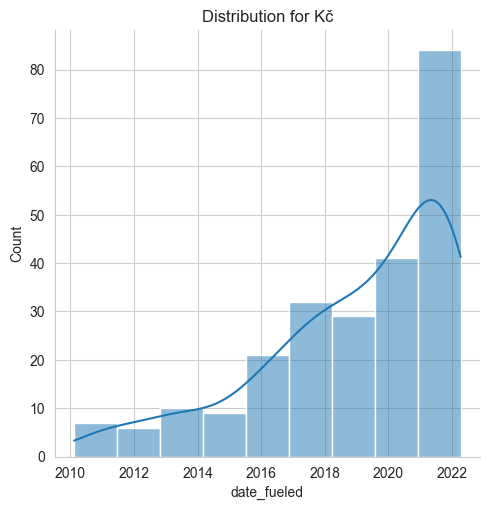

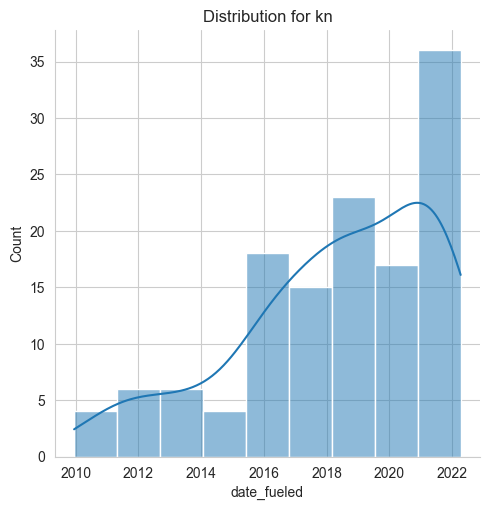

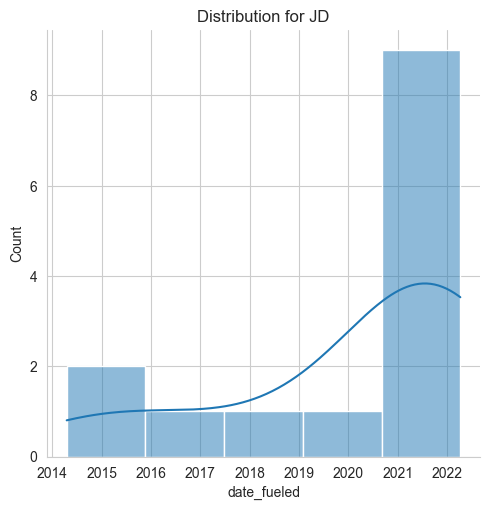

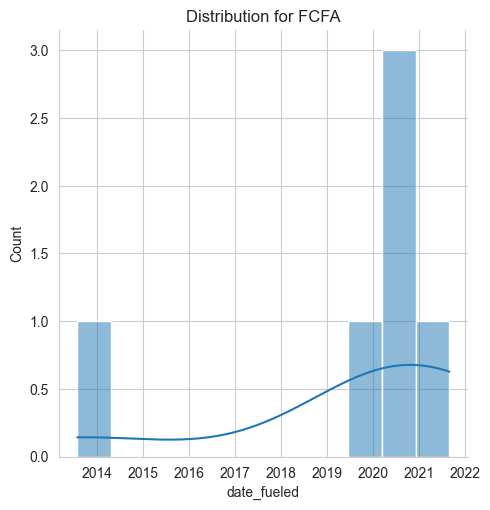

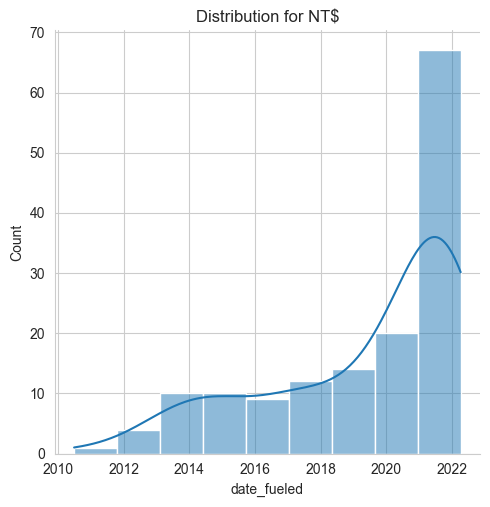

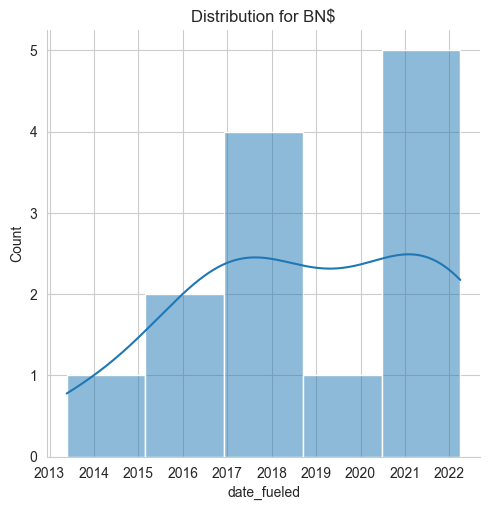

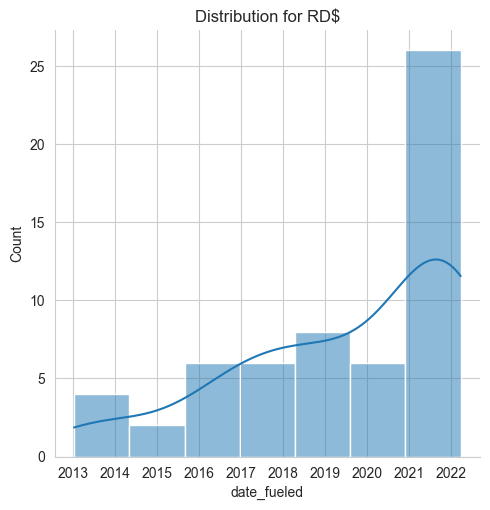

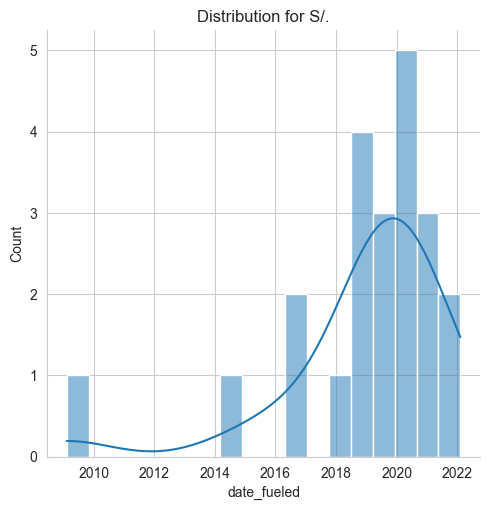

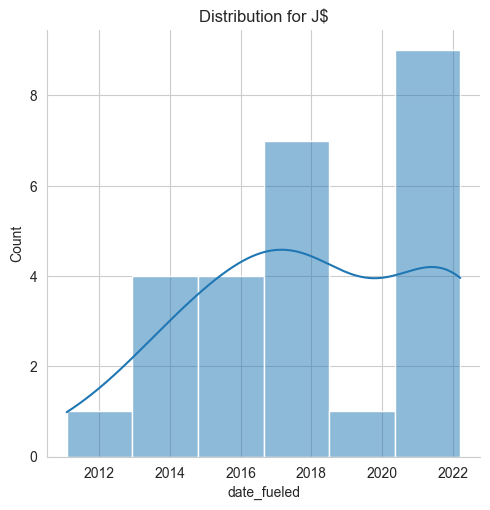

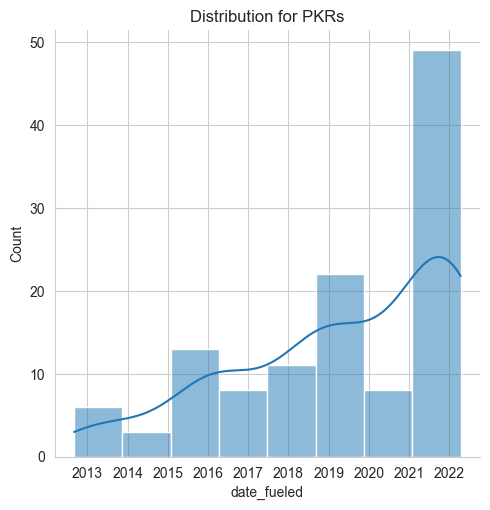

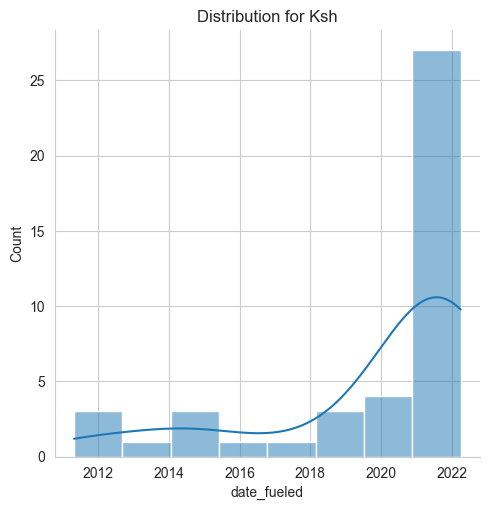

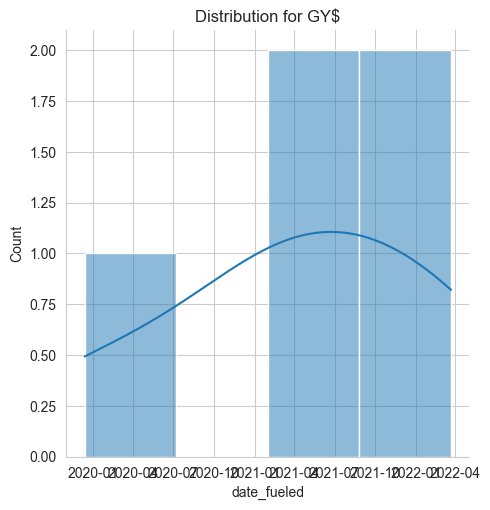

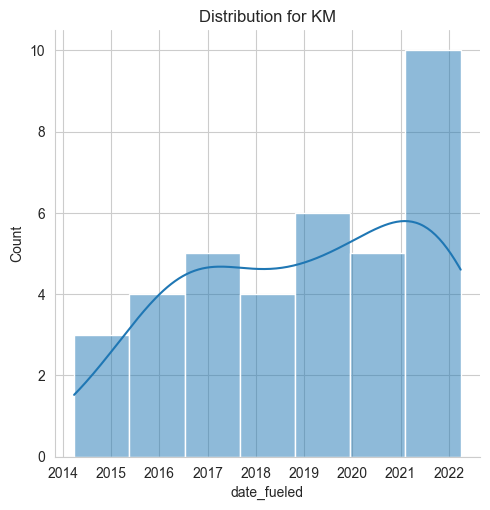

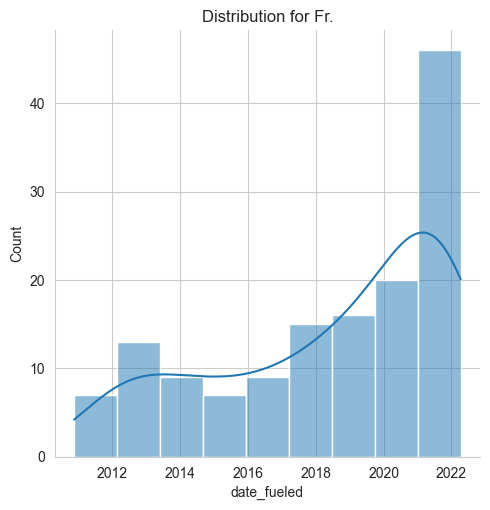

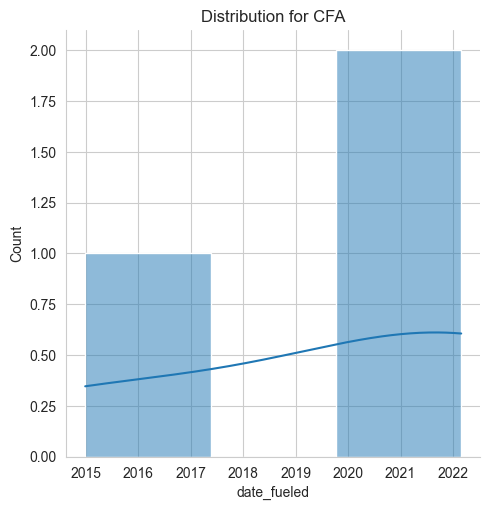

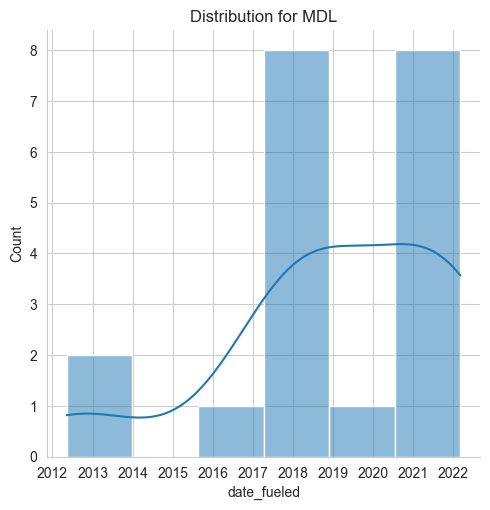

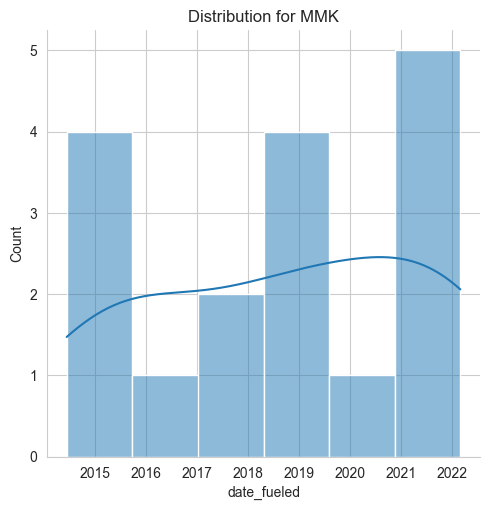

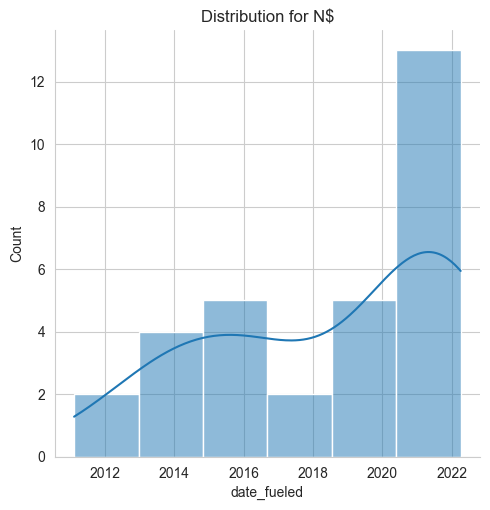

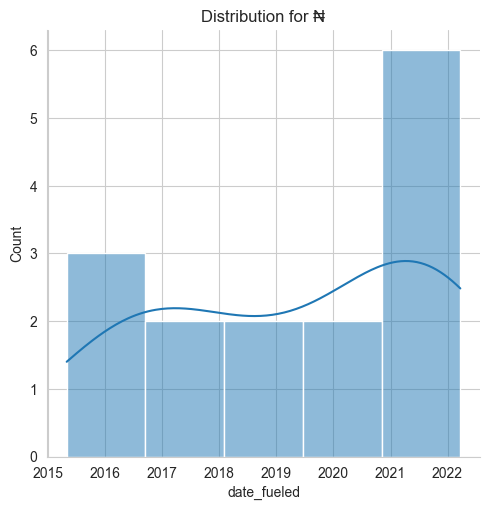

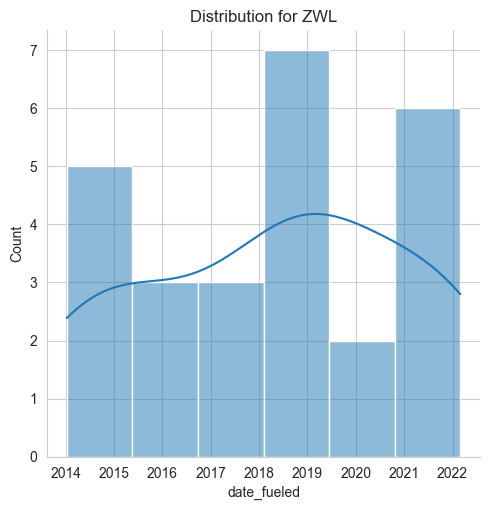

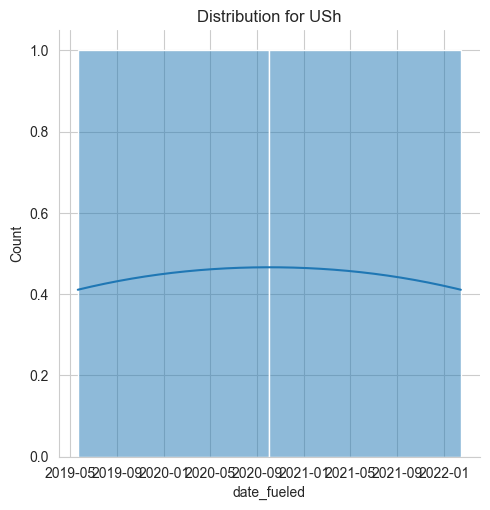

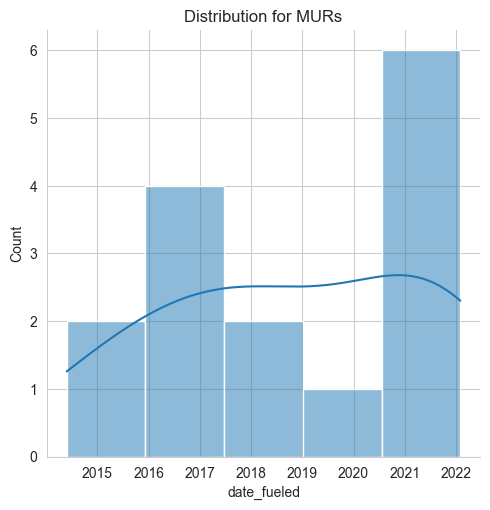

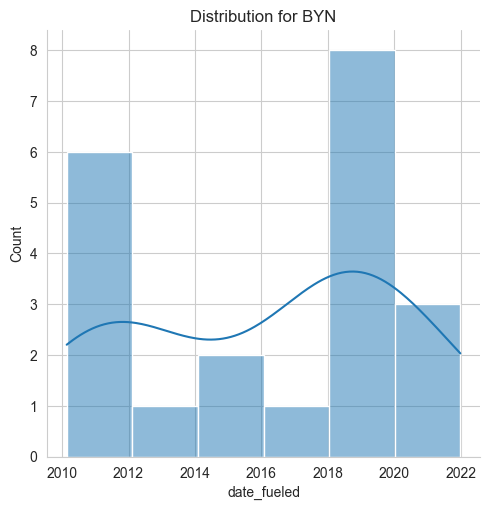

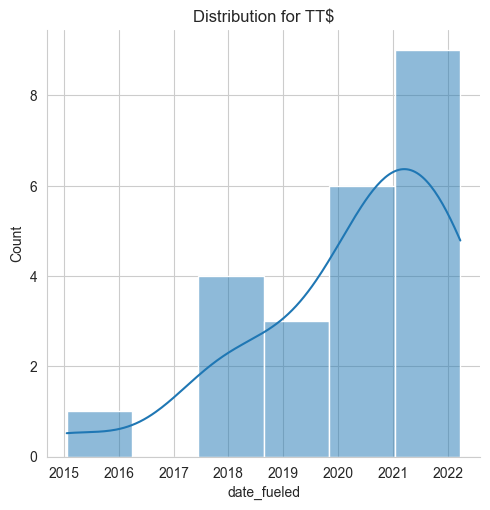

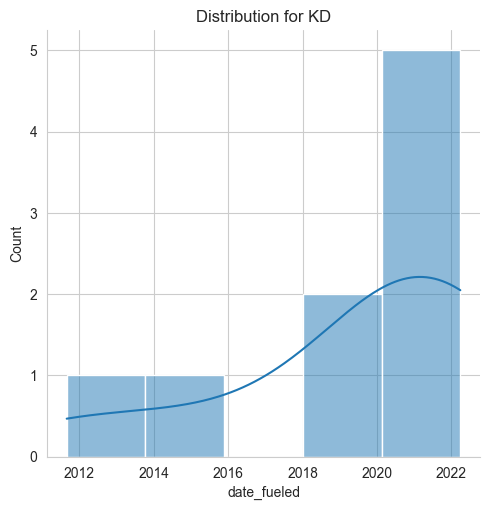

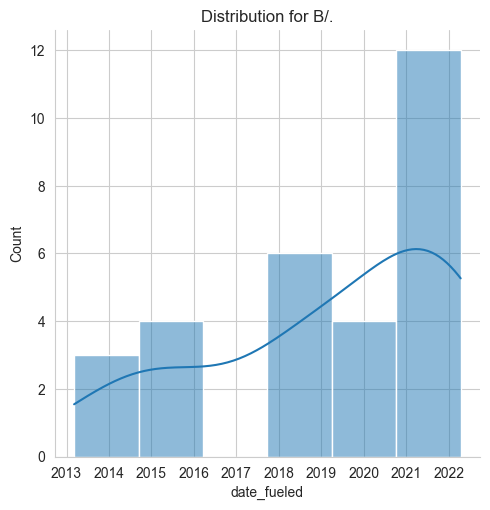

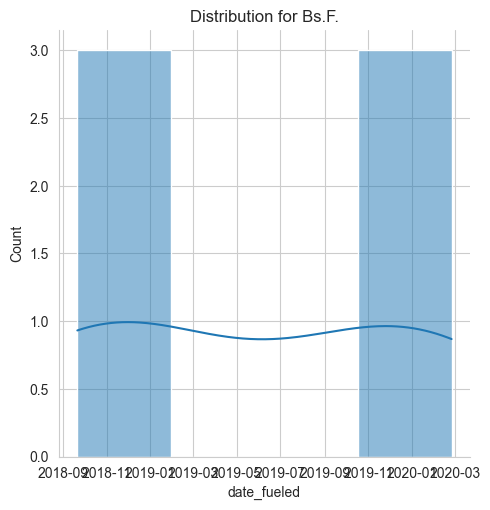

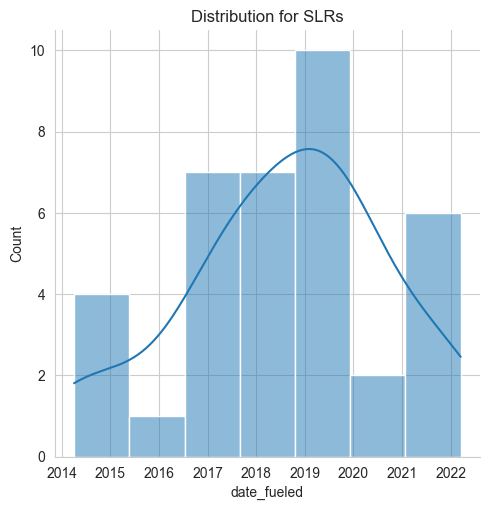

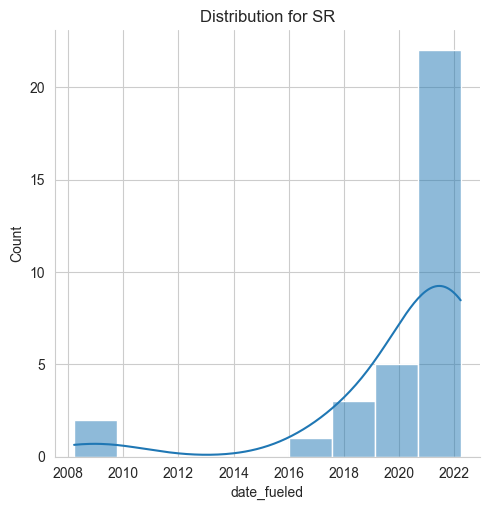

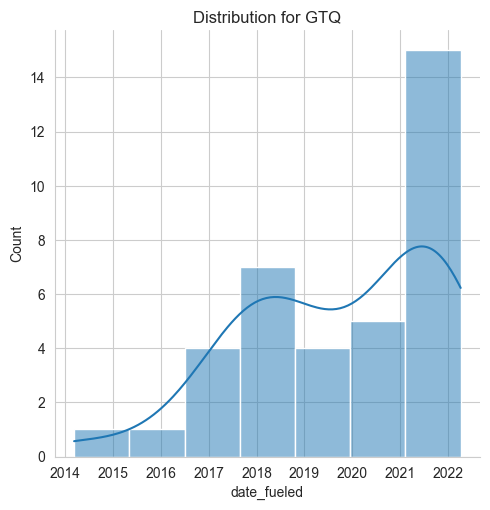

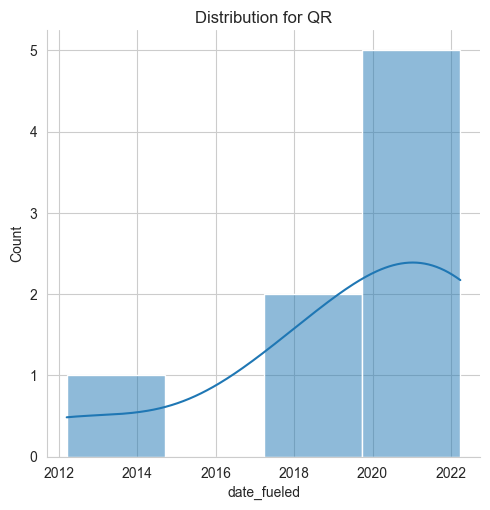

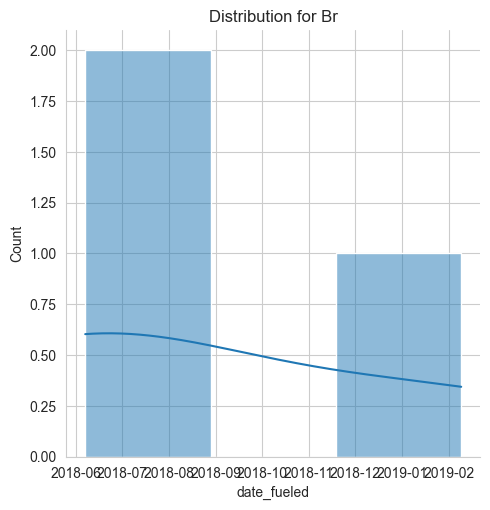

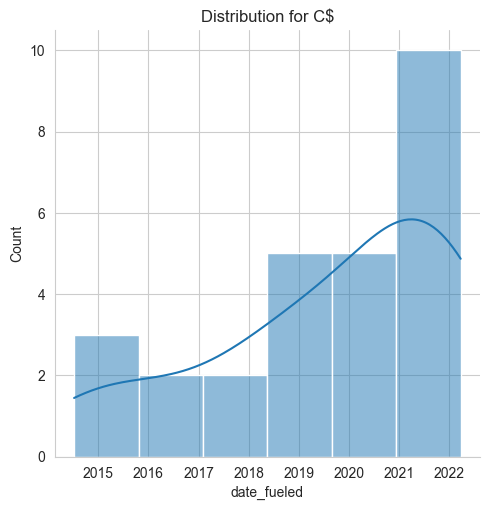

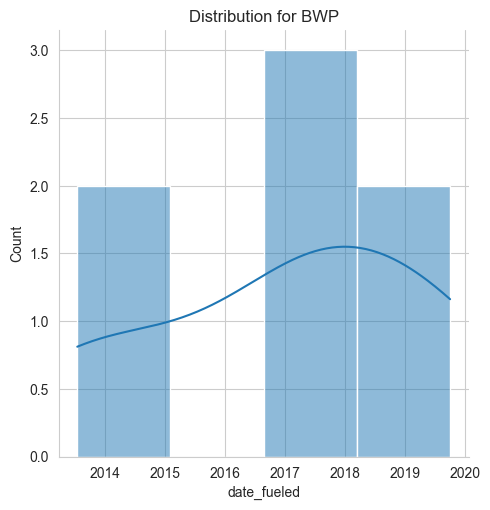

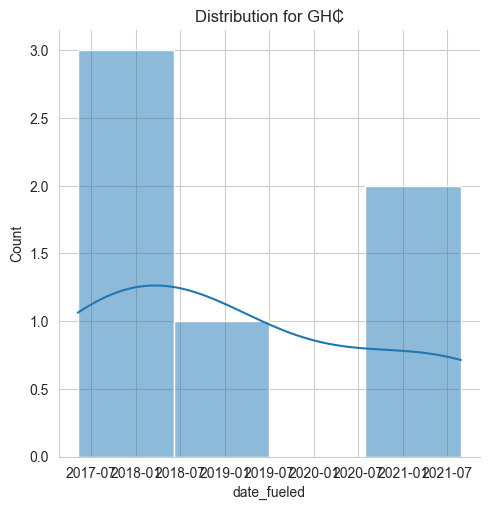

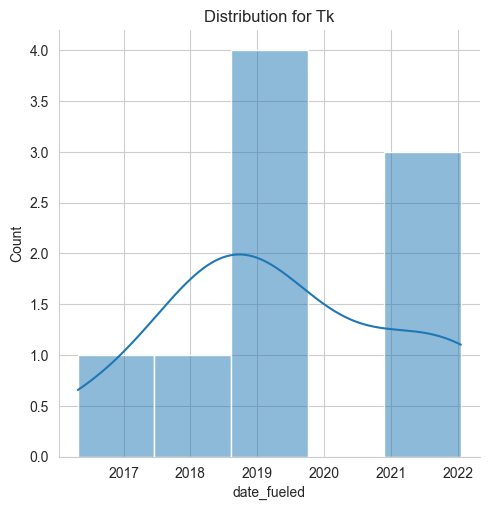

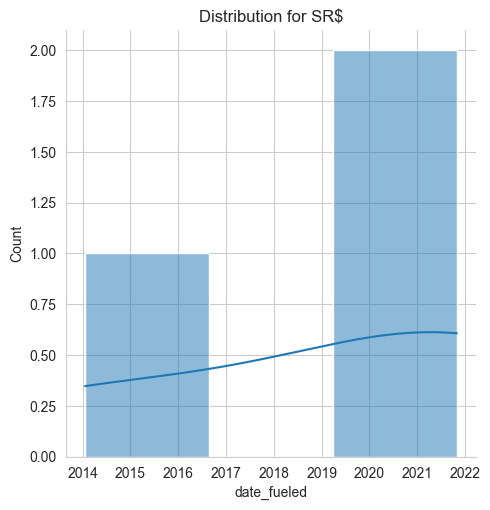

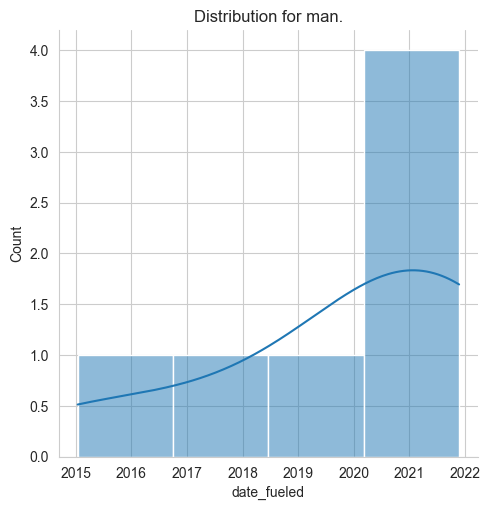

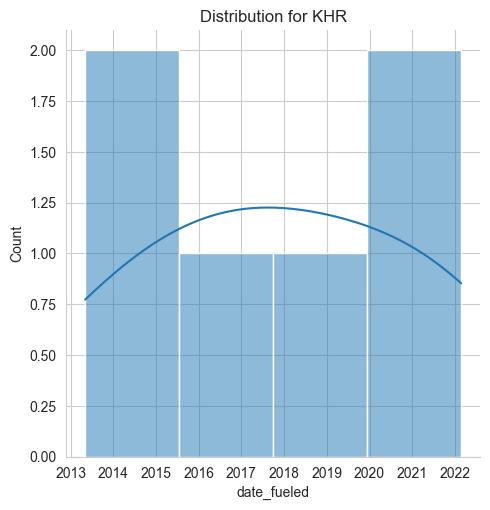

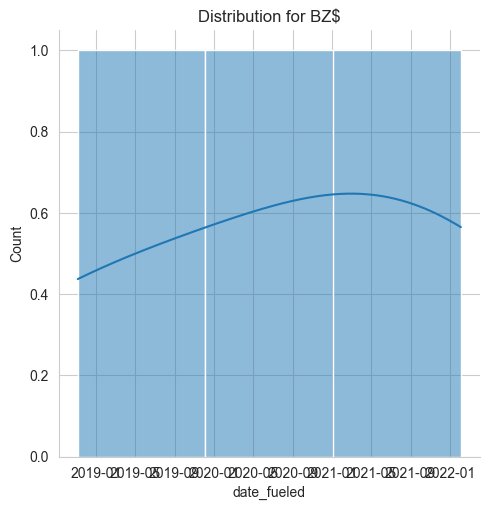

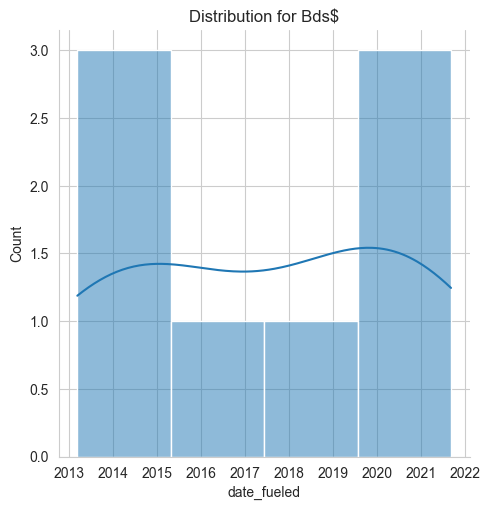

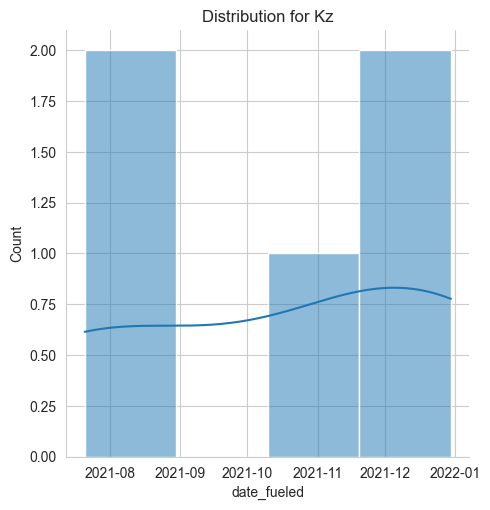

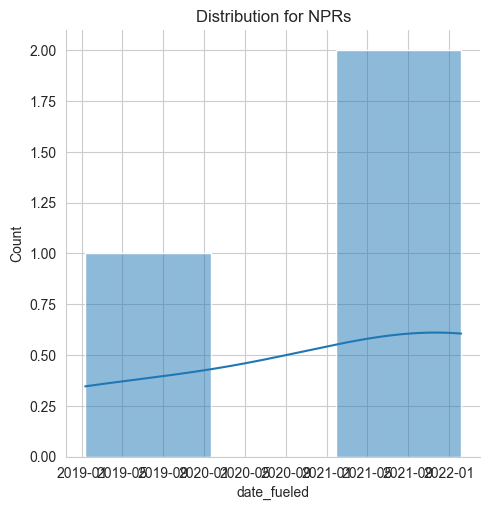

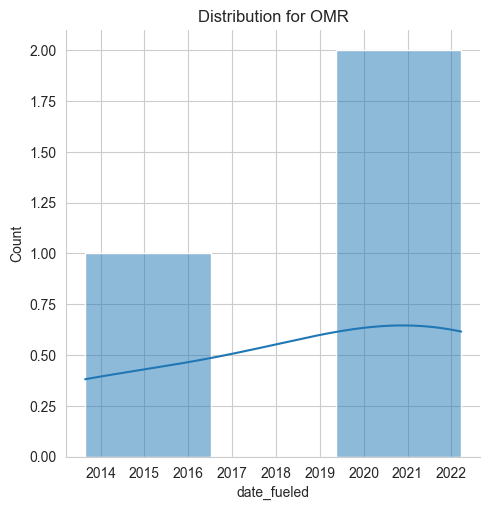

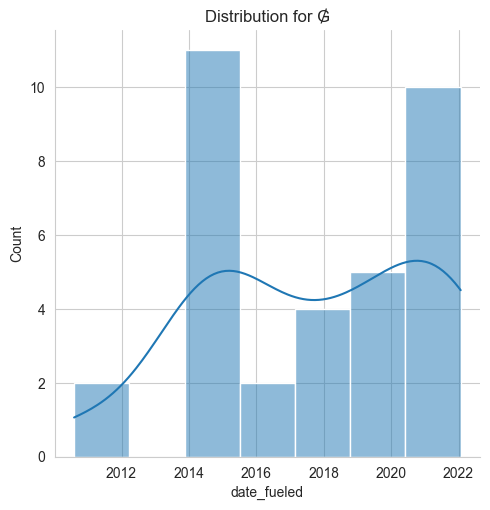

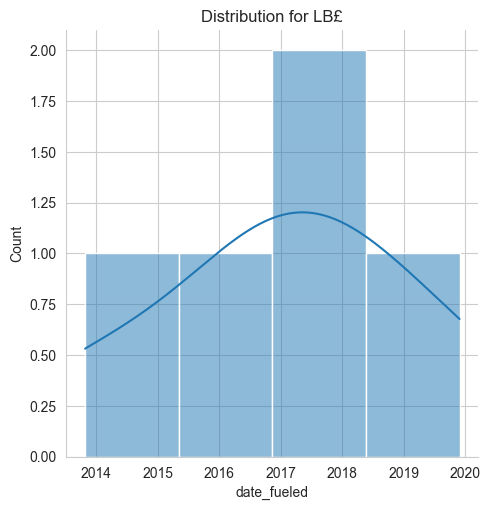

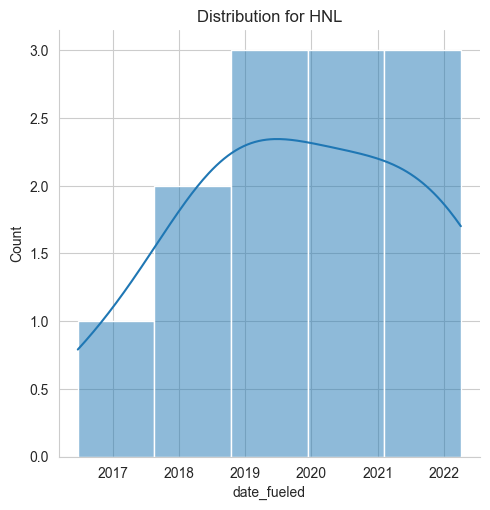

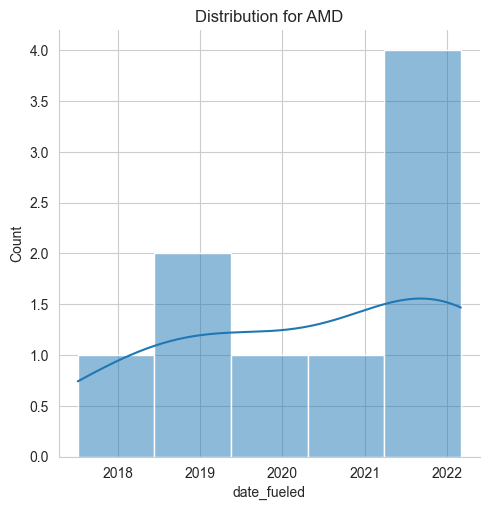

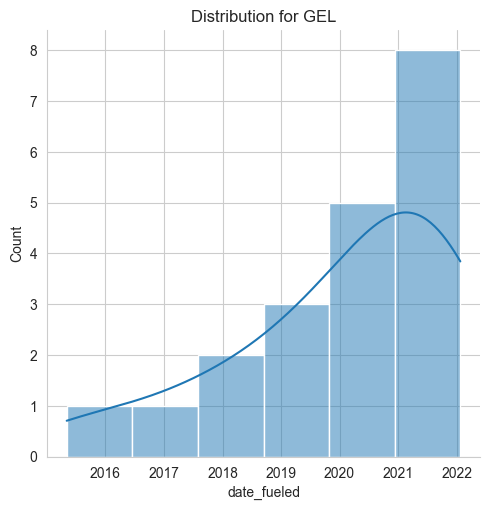

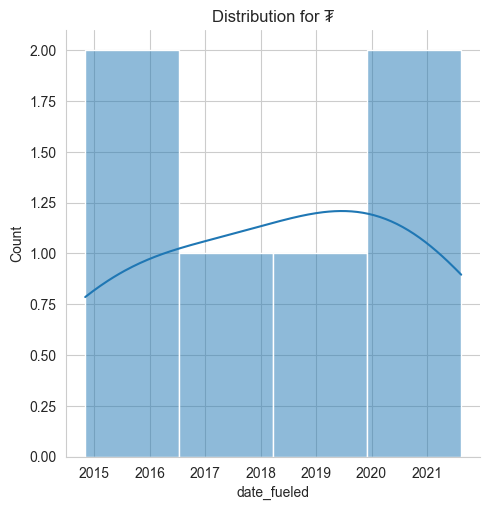

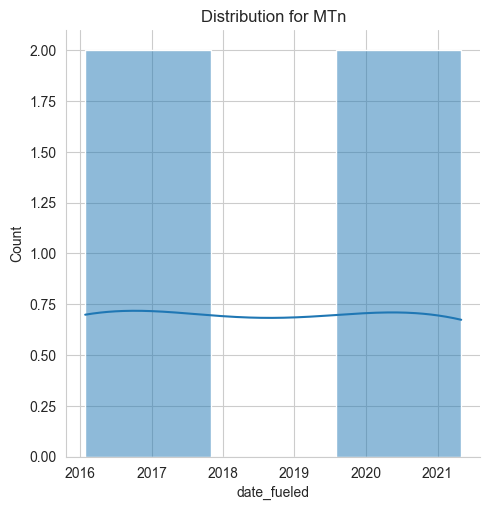

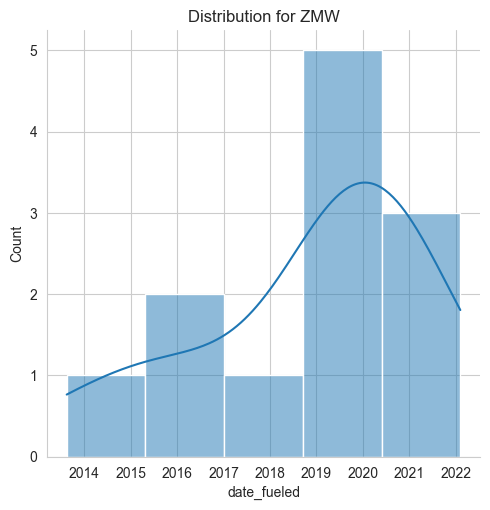

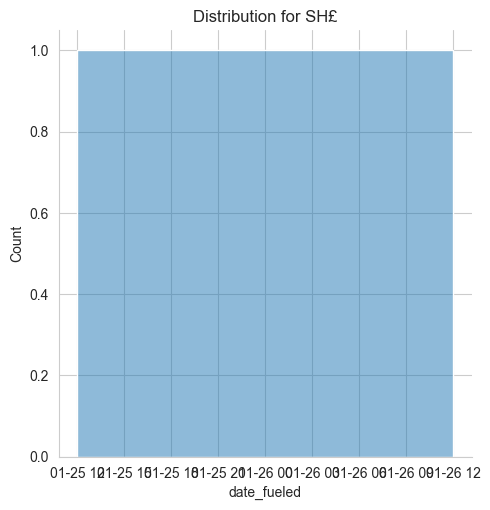

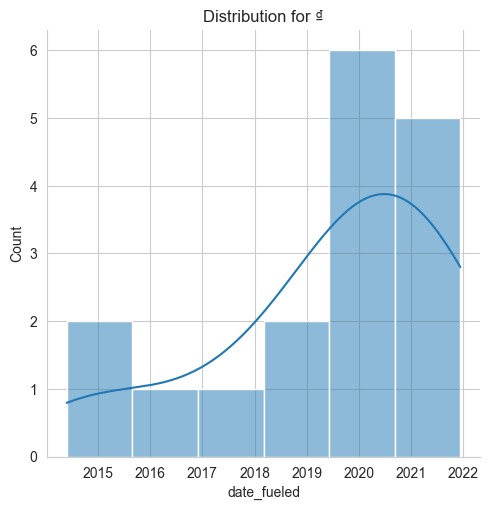

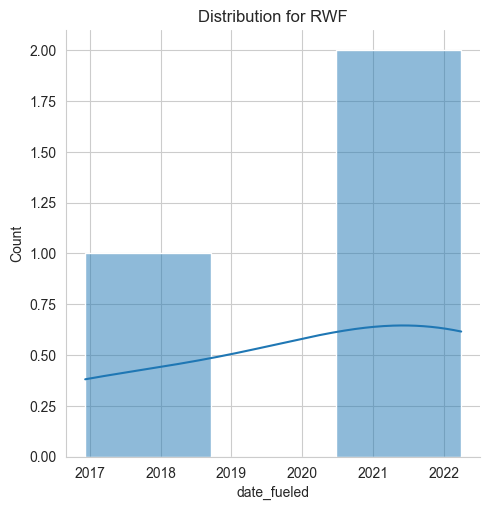

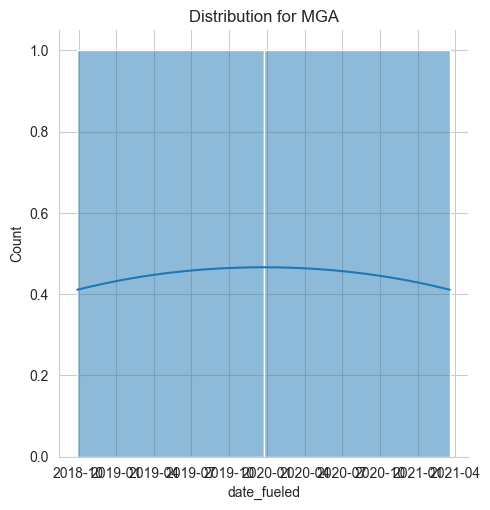

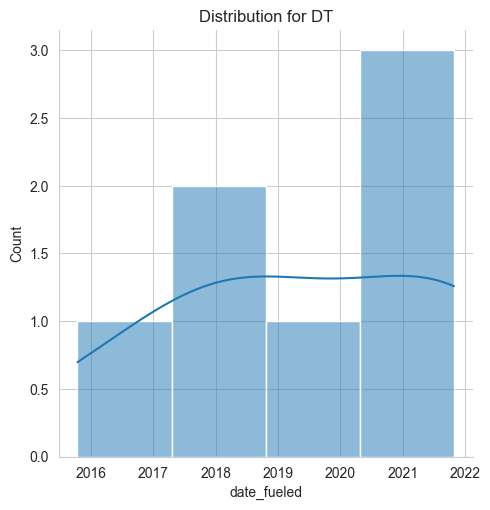

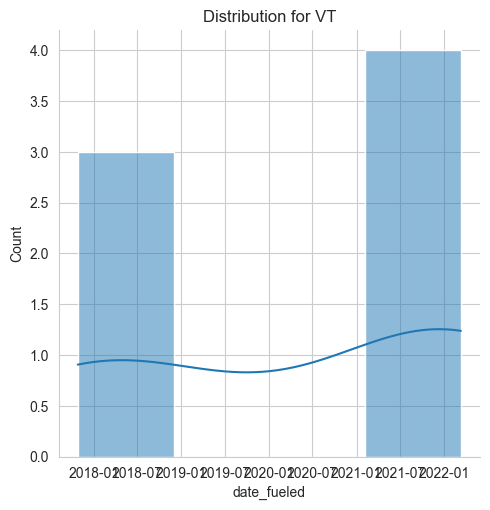

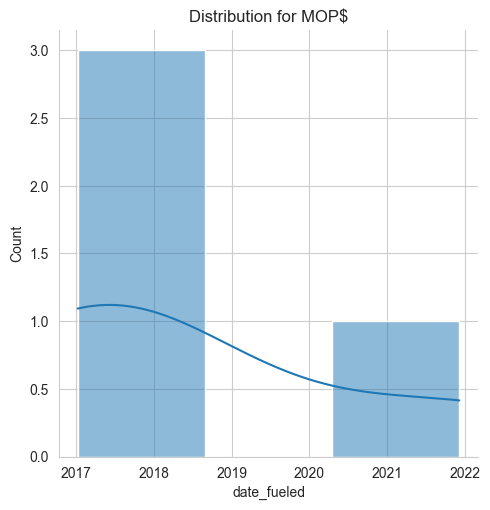

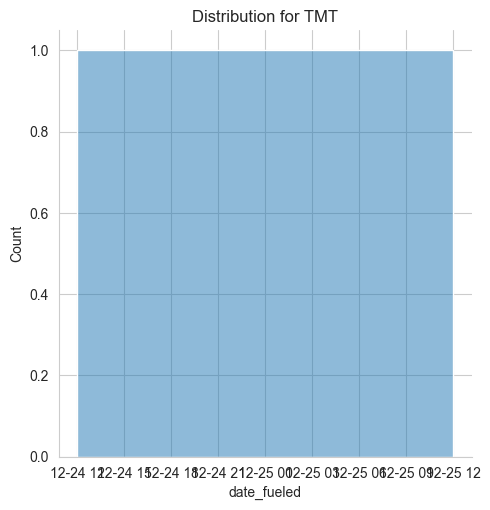

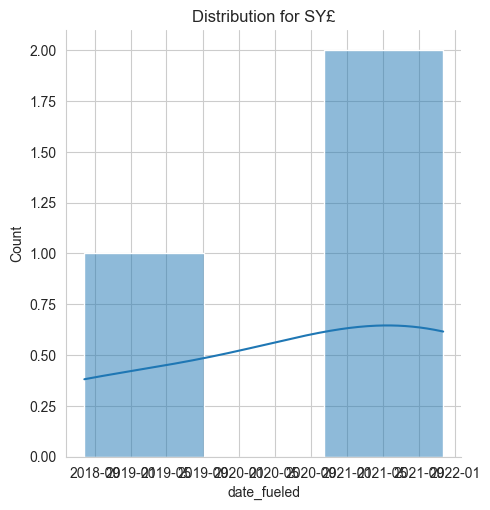

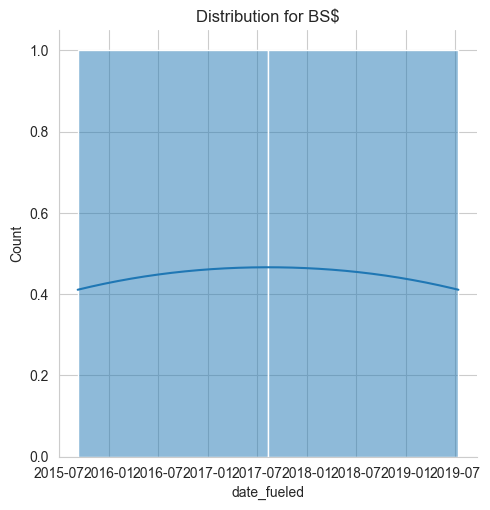

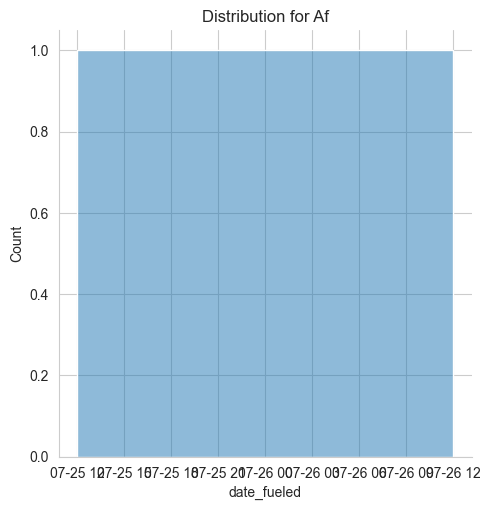

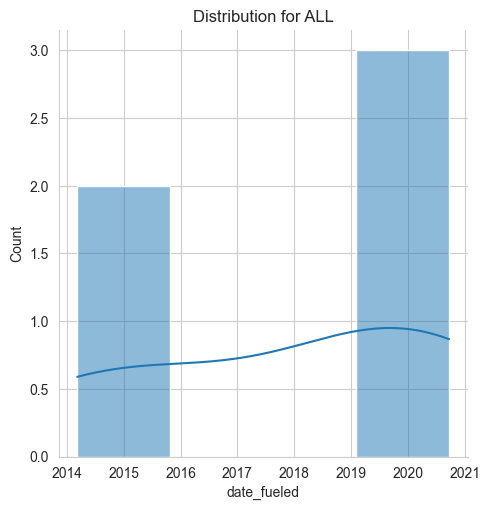

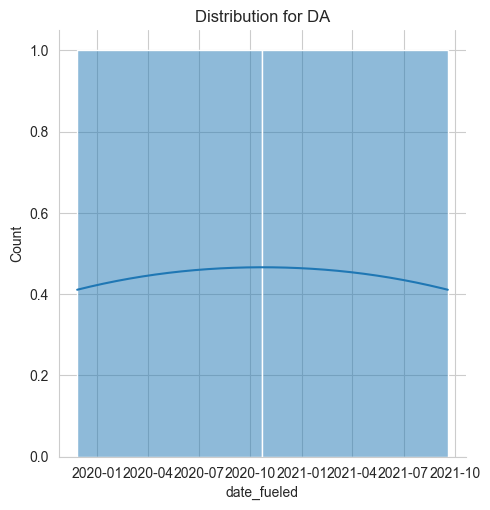

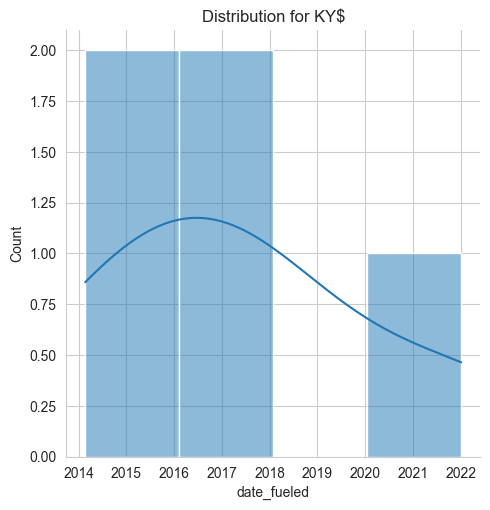

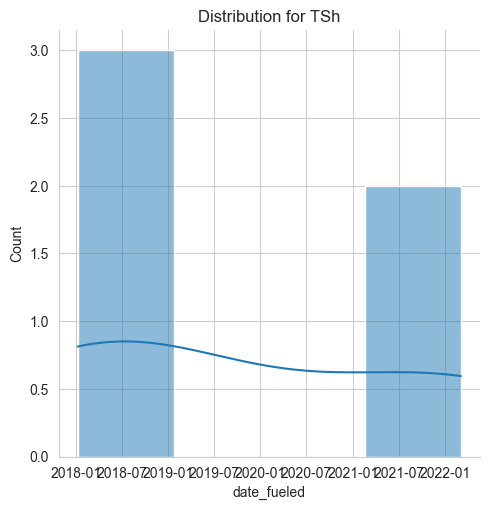

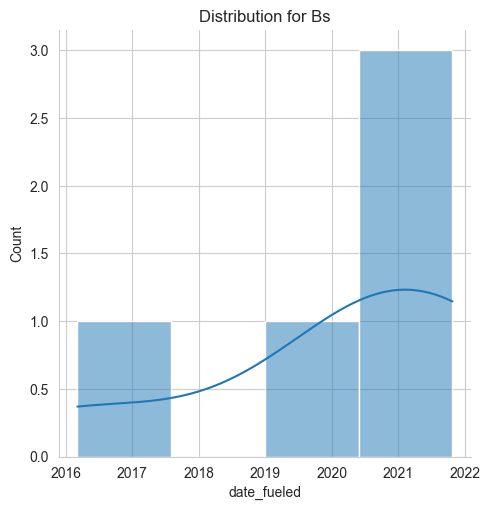

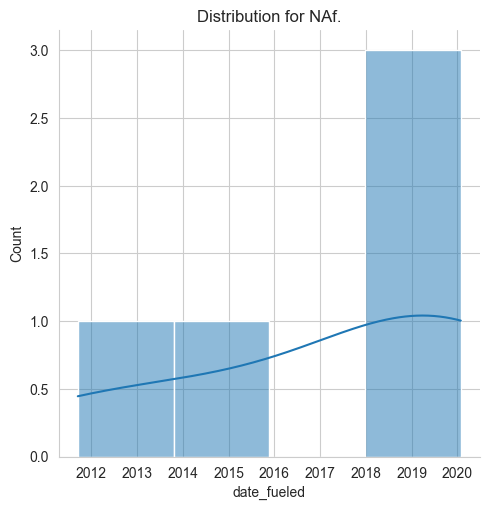

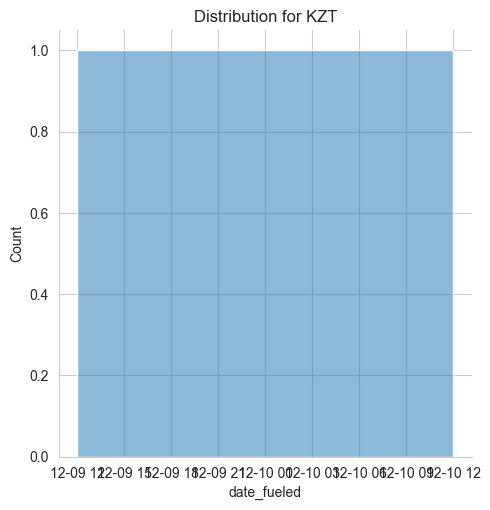

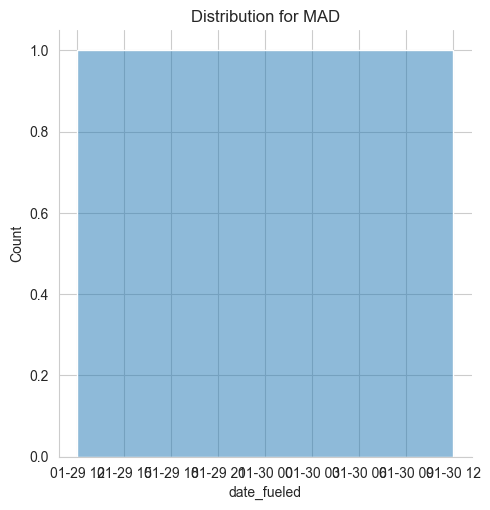

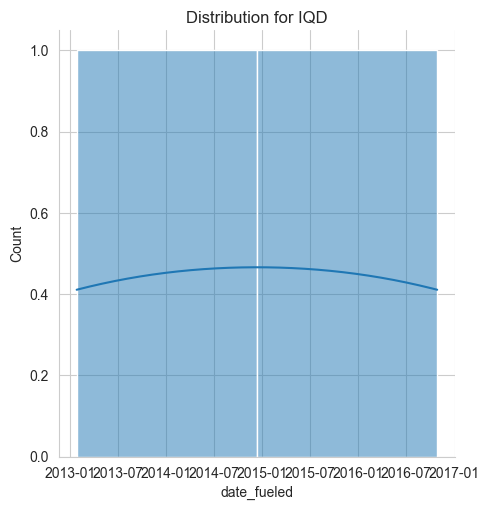

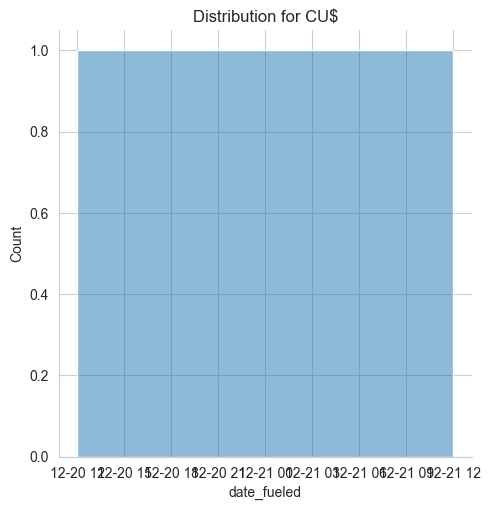

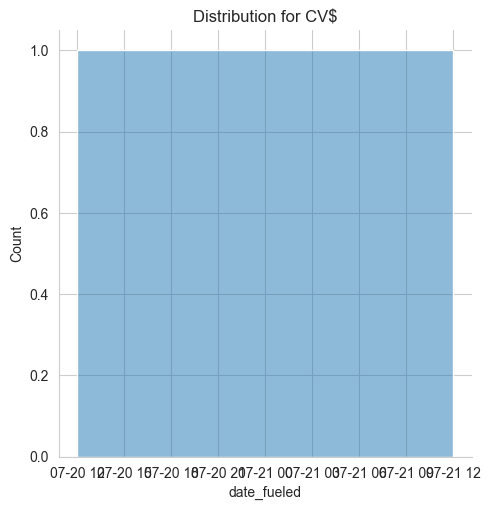

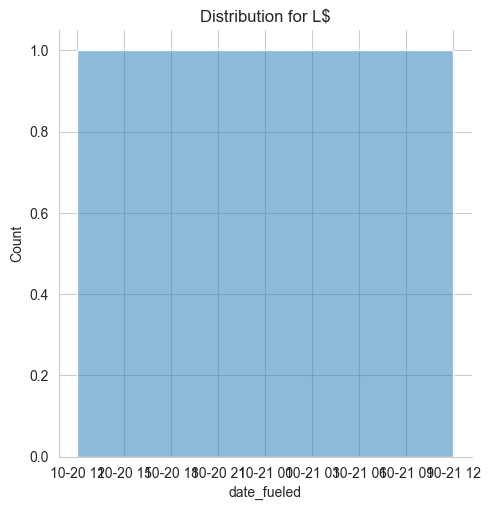

In [19]:

series_fueled_year = unique_users_df['date_fueled'].dt.year
df_fueled_year = unique_users_df.copy()
df_fueled_year['year_fueled'] = series_fueled_year
#sns.displot(data=unique_users_df, x="date_fueled", kde=True)
#row='currency'


#sns.displot(data = unique_users_df, x="date_fueled", kde=True,height=5, aspect=1)


countries = unique_users_df['currency'].unique()

for country in countries:
    sns.displot(data=unique_users_df[unique_users_df['currency'] == country], 
                x="date_fueled", kde=True, height=5, aspect=1)
    plt.title(f'Distribution for {country}')
    plt.show()  # or plt.savefig(f'{country}_distribution.png') to save the plot



#### [3.4] makes and models of vehicles are the most popular?

In [43]:
cars_unique_users_df = unique_users_df.copy()
# Function to extract make, model, year, and user ID
def extract_car_details(url):
    # Remove 'https://www.somewebsite.com/' and split by '/'
    parts = url.replace('https://www.somewebsite.com/', '').split('/')
    
    if len(parts) == 4:
        # do normally
        make = parts[0]
        model = parts[1]
        year = parts[2]
        user_id = parts[3]
    elif len(parts) == 3:
        # handle mispelled ones with out a model
        # make = parts[0]
        # can potentially be:
        make = "incorrect_make"
        # or
        # make = "other"
        model = "not applicable"
        year = parts[1]
        user_id = parts[2]
    elif len(parts) == 5:
        # handle ones that have extra "other" part 
        # ignore first other part
        make = parts[1]
        model = parts[2]
        year = parts[3]
        user_id = parts[4]

    ## Initialize extracted values
    #make = parts[0] if len(parts) > 0 else None
    #model = parts[1] if len(parts) > 1 else None
    #year = parts[2] if len(parts) > 2 else None
    #user_id = parts[3] if len(parts) > 3 else None
    
    return pd.Series([make, model, year, user_id])

# Apply the function to extract details and add new columns to the DataFrame
cars_unique_users_df[['make', 'model', 'year', 'user_id']] = cars_unique_users_df['user_url'].apply(extract_car_details)
#cars_unique_users_df.tail()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,is_valid_date,cost_per_gallon_float,total_spent_float,currency,total_spend,make,model,year,user_id
1173642,2021-12-07,2021-12-07,78339.0,4.348,$2.999,$13.04,0.0,0.0000,https://www.somewebsite.com/mercedes-benz/ml50...,True,2.999,13.04,$,13.039652,mercedes-benz,ml500,2002,1114657
1173895,2011-09-12,2011-09-12,NaN,2.031,€4.92,€9.99,0.0,115.6000,https://www.somewebsite.com/opel/corsa/2001/84695,True,4.920,9.99,€,9.992520,opel,corsa,2001,84695
1174089,2015-07-25,2016-09-03,123438.0,21.780,$2.679,$58.35,43.6,949.6080,https://www.somewebsite.com/ford/windstar/2001...,True,2.679,58.35,$,58.348620,ford,windstar,2001,488741
1174343,2013-04-15,2013-04-15,NaN,12.940,CA$5.41,CA$69.99,18.2,235.3000,https://www.somewebsite.com/bmw/540i/1997/178372,True,5.410,69.99,CA$,70.005400,bmw,540i,1997,178372
1174833,2016-09-05,2016-09-05,57386.0,10.374,€4.92,€51.01,37.8,392.1372,https://www.somewebsite.com/fiat/punto/2004/43...,True,4.920,51.01,€,51.040080,fiat,punto,2004,431536


In [48]:
# Display examples to show that the handling of car details worked
display(cars_unique_users_df[cars_unique_users_df["make"]=="suzukiry"])
display(cars_unique_users_df[cars_unique_users_df["make"]=="other"])
display(cars_unique_users_df[cars_unique_users_df["make"]=="volkswagenavelle"])

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,is_valid_date,cost_per_gallon_float,total_spent_float,currency,total_spend,make,model,year,user_id


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,is_valid_date,cost_per_gallon_float,total_spent_float,currency,total_spend,make,model,year,user_id


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,is_valid_date,cost_per_gallon_float,total_spent_float,currency,total_spend,make,model,year,user_id


make
ford              14395
toyota            13452
bmw               11059
nissan             8840
volkswagen         7679
mercedes-benz      6636
honda              6162
audi               5760
hyundai            4983
mazda              4664
lexus              3995
kia                3832
volvo              3680
mitsubishi         3494
jeep               3275
subaru             3207
land_rover         2160
suzuki             2058
peugeot            1890
renault            1741
fiat               1661
citroen            1437
opel               1101
alfa_romeo          908
mini                809
isuzu               630
incorrect_make      486
tata                 94
mahindra             52
Name: count, dtype: int64

model
mustang            815
f-150              780
land_cruiser       751
civic              743
corolla            737
                  ... 
duna                 1
presea               1
e-200_econoline      1
mk_ii                1
a200d                1
Name: count, Length: 2185, dtype: int64

<Axes: xlabel='count', ylabel='model'>

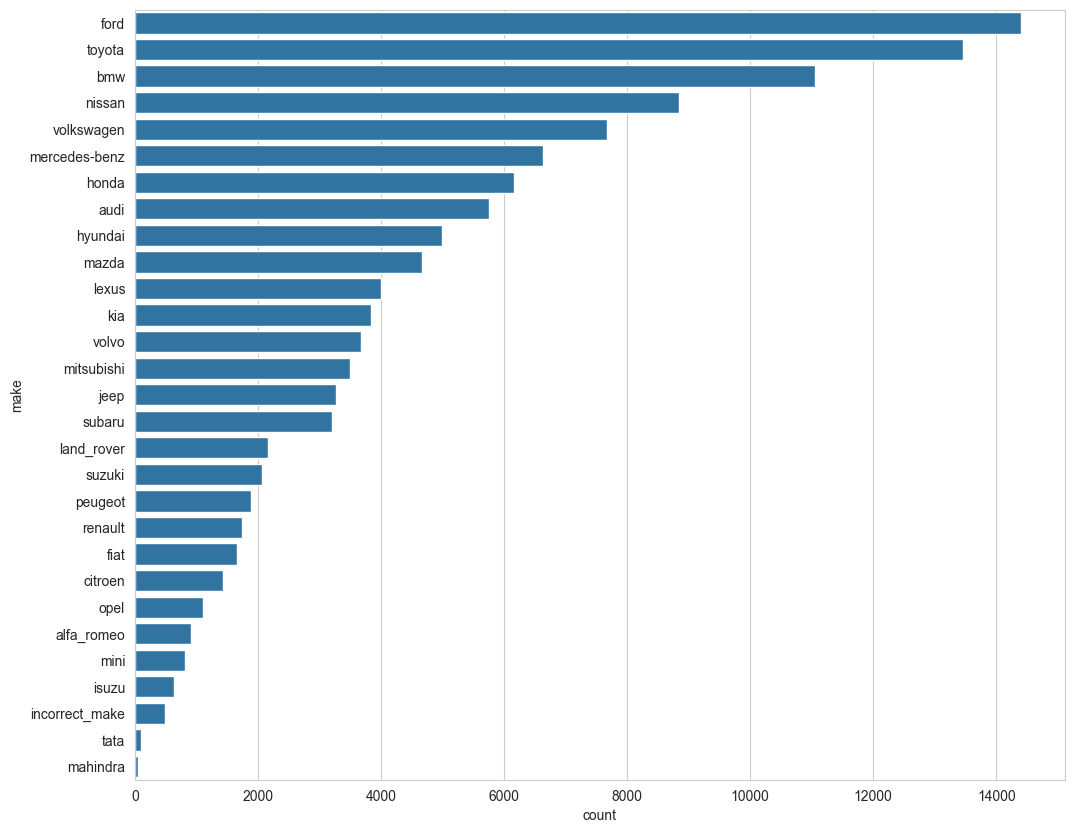

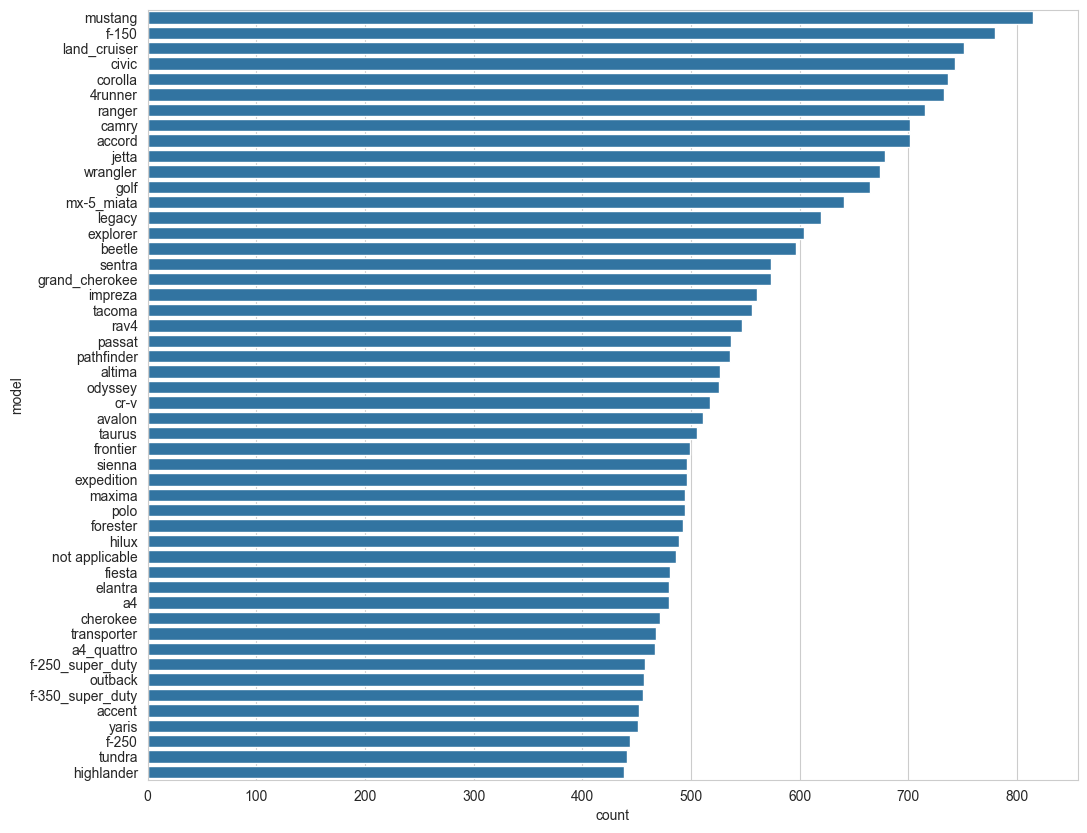

In [47]:
car_make_counts  = cars_unique_users_df['make'].value_counts()
car_model_counts = cars_unique_users_df['model'].value_counts()
car_year_counts  = cars_unique_users_df['year'].value_counts()

plt.figure(figsize=(12,10))
display(car_make_counts)
sns.barplot(car_make_counts, orient='y')
plt.figure(figsize=(12,10))
display(car_model_counts)
sns.barplot(car_model_counts.head(50), orient='y')